**ОГЛАВЛЕНИЕ**

<a href='#description'>Предсказание успешности стартапа</a>

<a href='#1'>1  Загрузка и подготовка данных</a>

<a href='#2'>2 Предобработка данных</a>

<a href='#3'>3  Исследовательский анализ данных</a>

<a href='#4'>4  Корреляционный анализ</a>

<a href='#5'>5  Обучение модели и использование пайплайнов</a>

<a href='#6'>6  Итоговая таблица с предсказаниями</a>

<a href='#7'>7  Важность признаков</a>

<a href='#8'>8  Выводы</a>

<a id='description'></a>
# Предсказание успешности стартапа

В этом конкурсе ваша задача - разработать модель для предсказания успешности стартапа (закроется или нет)

Данные
Датасет состоит из двух файлов: тренировочный набор (около 53к записей) и тестовый набор (около 13к записей). Тренировочный набор содержит целевой признак status, указывающий на то, закрылся стартап или продолжает действовать. Временной период - '1970-01-01' по '2018-01-01'. Дата формирования выгрузки - '2018-01-01'

kaggle_startups_train_01.csv - информация (53 000) стартапах, которые будут использоваться в качестве обучающих данных.

kaggle_startups_test_01.csv - информация (13 000) стартапах, которые будут использоваться в качестве тестовых данных.

**Ваша задача - предсказать значение 'status' для каждого стартапа из этого датасета.**

kaggle_startups_sample_submit_01.csv - файл с примером предсказаний в правильном формате.

name - идентификатор (название) стартапа в тестовом наборе.

status - целевой признак. Для каждого стартапа предскажите категориальное значение соответствующее прогнозу ['operating', 'closed'].

Описание полей данных

name - Название стартапа

category_list - Список категорий, к которым относится стартап

funding_total_usd - Общая сумма финансирования в USD

status - Статус стартапа (закрыт или действующий)

country_code - Код страны

state_code - Код штата

region - Регион

city - Город

funding_rounds - Количество раундов финансирования

founded_at - Дата основания

first_funding_at - Дата первого раунда финансирования

last_funding_at - Дата последнего раунда финансирования

closed_at - Дата закрытия стартапа (если применимо)

lifetime - Время существования стартапа в днях

In [1]:
!pip install phik -q

!pip install scikit-learn==1.1.3 -q

!pip install shap -q

!pip install optuna -q

!pip install optuna-integration -q

!pip install catboost -q

In [2]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
pd.options.mode.chained_assignment = None

import seaborn as sns
from matplotlib import pyplot as plt

from phik.report import correlation_report, plot_correlation_matrix


from scipy import stats as st
from sklearn.compose import make_column_transformer
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

from sklearn.ensemble import HistGradientBoostingClassifier
from catboost import CatBoostClassifier

from sklearn.linear_model import(
    Ridge,
    RidgeClassifier,
    LinearRegression,
    LogisticRegression,
) 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVC
from sklearn.metrics import (
    mean_squared_error,
    roc_curve,
    roc_auc_score,
    f1_score,
    make_scorer
)

from sklearn.metrics import (accuracy_score,
                             confusion_matrix,
                             mean_absolute_error, 
                             mean_squared_error,
                             precision_score,
                             recall_score,
                             r2_score
                            )
    
from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV,
    train_test_split
)

from optuna.integration import OptunaSearchCV
from optuna import distributions

from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import (
    OneHotEncoder,
    OrdinalEncoder,
    StandardScaler,
    MinMaxScaler,
    RobustScaler,
    LabelEncoder
)

import shap
from sklearn.feature_selection import SelectKBest, f_classif

from shap import Explanation, KernelExplainer
from shap.plots import waterfall, beeswarm

import datetime
from datetime import date
from datetime import time

RANDOM_STATE = 42
TEST_SIZE = 0.25
dt0 = datetime.datetime(1970,1,1)
dt1 = datetime.datetime(2018,1,1)

<a id='1'></a>
## Загрузка и подготовка данных

In [3]:
try:
    startups_train = pd.read_csv('C:/Users/DAV.PC/Documents/PRACTICUM/Мастерская-1_стартапы/datasets/kaggle_startups_train_28062024.csv', sep=',')
    startups_test = pd.read_csv('C:/Users/DAV.PC/Documents/PRACTICUM/Мастерская-1_стартапы/datasets/kaggle_startups_test_28062024.csv', sep=',')

except:
    startups_train = pd.read_csv('/kaggle/input/startups-operations-close-predictions-m-1-43-ds/kaggle_startups_train_28062024.csv', sep=',')
    startups_test = pd.read_csv('/kaggle/input/startups-operations-close-predictions-m-1-43-ds/kaggle_startups_test_28062024.csv', sep=',')

In [4]:
def data_info(data):
    pd.set_option('display.max_columns', None)
    display(data.head())
    display(data.describe(include='all'))
    data.info()

In [5]:
data_info(startups_train)

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at
0,Lunchgate,Online Reservations|Restaurants,828626.0,operating,CHE,25,Zurich,Zürich,2,2009-10-17,2011-05-01,2014-12-01,NaN
1,EarLens,Manufacturing|Medical|Medical Devices,42935019.0,operating,USA,CA,SF Bay Area,Redwood City,4,2005-01-01,2010-05-04,2014-02-25,NaN
2,Reviva Pharmaceuticals,Biotechnology,35456381.0,operating,USA,CA,SF Bay Area,San Jose,3,2006-01-01,2012-08-20,2014-07-02,NaN
3,Sancilio and Company,Health Care,22250000.0,operating,NaN,NaN,NaN,NaN,3,2004-01-01,2011-09-01,2014-07-18,NaN
4,WireTough Cylinders,Manufacturing,NaN,operating,USA,VA,VA - Other,Bristol,1,2010-05-12,2012-02-01,2012-02-01,NaN


,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at
count,52515,50051,4.244700e+04,52516,47014,45753,46157,46157,52516.000000,52516,52516,52516,4917
unique,52515,22105,NaN,2,134,300,1036,4477,NaN,5402,4603,4305,3008
top,Appside,Software,NaN,operating,USA,CA,SF Bay Area,San Francisco,NaN,2012-01-01,2013-01-01,2014-01-01,2016-12-02
freq,1,3207,NaN,47599,29702,10219,6970,2824,NaN,2171,450,369,8
mean,NaN,NaN,1.824748e+07,NaN,NaN,NaN,NaN,NaN,1.740670,NaN,NaN,NaN,NaN
std,NaN,NaN,1.871173e+08,NaN,NaN,NaN,NaN,NaN,1.374522,NaN,NaN,NaN,NaN
min,NaN,NaN,1.000000e+00,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,NaN
25%,NaN,NaN,3.360275e+05,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,NaN
50%,NaN,NaN,2.000000e+06,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,NaN
75%,NaN,NaN,1.000000e+07,NaN,NaN,NaN,NaN,NaN,2.000000,NaN,NaN,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52516 entries, 0 to 52515
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   name               52515 non-null  object 
 1   category_list      50051 non-null  object 
 2   funding_total_usd  42447 non-null  float64
 3   status             52516 non-null  object 
 4   country_code       47014 non-null  object 
 5   state_code         45753 non-null  object 
 6   region             46157 non-null  object 
 7   city               46157 non-null  object 
 8   funding_rounds     52516 non-null  int64  
 9   founded_at         52516 non-null  object 
 10  first_funding_at   52516 non-null  object 
 11  last_funding_at    52516 non-null  object 
 12  closed_at          4917 non-null   object 
dtypes: float64(1), int64(1), object(11)
memory usage: 5.2+ MB


In [6]:
data_info(startups_test)

,name,category_list,funding_total_usd,country_code,state_code,region,city,funding_rounds,first_funding_at,last_funding_at,lifetime
0,Crystalsol,Clean Technology,2819200.0,NIC,17,NaN,NaN,1,2009-07-01,2009-07-01,3501
1,JBI Fish & Wings,Hospitality,NaN,USA,TN,TN - Other,Humboldt,1,2010-07-28,2010-07-28,2717
2,COINPLUS,Finance,428257.0,LUX,3,Esch-sur-alzette,Esch-sur-alzette,2,2014-05-15,2014-09-18,1295
3,Imagine Communications,Software|Video|Video Streaming,34700000.0,USA,CA,San Diego,San Diego,4,2005-01-01,2010-04-20,4748
4,DNA13,Software,4530000.0,CAN,ON,Ottawa,Ottawa,1,2007-05-08,2007-05-08,6209


,name,category_list,funding_total_usd,country_code,state_code,region,city,funding_rounds,first_funding_at,last_funding_at,lifetime
count,13125,12534,1.054700e+04,11743,11430,11536,11538,13125.000000,13125,13125,13125.000000
unique,13125,6206,NaN,96,235,688,2117,NaN,3299,3021,NaN
top,FitWell,Software,NaN,USA,CA,SF Bay Area,San Francisco,NaN,2014-01-01,2014-01-01,NaN
freq,1,775,NaN,7428,2552,1750,656,NaN,126,111,NaN
mean,NaN,NaN,1.654910e+07,NaN,NaN,NaN,NaN,1.714438,NaN,NaN,3097.609524
std,NaN,NaN,9.217283e+07,NaN,NaN,NaN,NaN,1.318800,NaN,NaN,2128.356554
min,NaN,NaN,1.000000e+00,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,52.000000
25%,NaN,NaN,3.200000e+05,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,1726.000000
50%,NaN,NaN,2.000000e+06,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,2526.000000
75%,NaN,NaN,1.000000e+07,NaN,NaN,NaN,NaN,2.000000,NaN,NaN,3866.000000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13125 entries, 0 to 13124
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   name               13125 non-null  object 
 1   category_list      12534 non-null  object 
 2   funding_total_usd  10547 non-null  float64
 3   country_code       11743 non-null  object 
 4   state_code         11430 non-null  object 
 5   region             11536 non-null  object 
 6   city               11538 non-null  object 
 7   funding_rounds     13125 non-null  int64  
 8   first_funding_at   13125 non-null  object 
 9   last_funding_at    13125 non-null  object 
 10  lifetime           13125 non-null  int64  
dtypes: float64(1), int64(2), object(8)
memory usage: 1.1+ MB


In [7]:
startups_submit = pd.read_csv('C:/Users/DAV.PC/Documents/PRACTICUM/Мастерская-1_стартапы/datasets/kaggle_startups_sample_submit_28062024.csv', sep=',')

In [8]:
startups_submit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13125 entries, 0 to 13124
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   name    13125 non-null  object
 1   status  13125 non-null  object
dtypes: object(2)
memory usage: 205.2+ KB


<a id='2'></a>
## Предобработка данных

Выведем долю пропущенных значений для каждого столбца датафреймов.

In [9]:
pd.DataFrame(startups_train.isna().mean()*100)

,0
name,0.001904
category_list,4.693808
funding_total_usd,19.173204
status,0.000000
country_code,10.476807
state_code,12.877980
region,12.108691
city,12.108691
funding_rounds,0.000000
founded_at,0.000000


In [10]:
pd.DataFrame(startups_test.isna().mean()*100)

,0
name,0.000000
category_list,4.502857
funding_total_usd,19.641905
country_code,10.529524
state_code,12.914286
region,12.106667
city,12.091429
funding_rounds,0.000000
first_funding_at,0.000000
last_funding_at,0.000000


Посмотрим, есть ли строки дубликаты в представленных данных.

In [11]:
startups_train.duplicated().sum()

0

In [12]:
startups_test.duplicated().sum()

0

Истинных дубликатов в представленных датафреймах нет.

In [13]:
startups_train['name'].duplicated().sum()

0

In [14]:
startups_test['name'].duplicated().sum()

0

Строк одинаковыми названиями стартапов нет.

К сожалению, в некотрых полях присутствует до 20% пропусков, которые невозможно заполнить искусственно, а выбрасывать такое количество данных нельзя. Поэтому оставим, как есть.

Также можно заметить, что в тестовых данных присутствует время существования стартапа в днях (lifetime). Этого поля нет в тренировочных данных, но его можно восстановить, воспользовавшись данными из столбцов founded_at, closed_at и даты выгрузки данных.

Найдем строки, в которых нет имени стартапа, и удалим их.

In [15]:
startups_train[startups_train['name'].isnull()]

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at
3291,NaN,Startups,25000.0,closed,USA,OR,"Portland, Oregon",Portland,1,2011-10-01,2012-03-01,2012-03-01,2013-06-03


In [16]:
startups_train = startups_train.dropna(subset=['name']).reset_index(drop= True)

Переведем даты в формат datetime, чтобы потом взять от них только год. Маловероятно, что месяц и дата финансирования раундов оказывают влияние на судьбу стартапа.

In [17]:
startups_train['founded_at'] = pd.to_datetime(startups_train['founded_at'], format='%Y-%m-%d')
startups_train['closed_at'] = pd.to_datetime(startups_train['closed_at'], format='%Y-%m-%d')
startups_train['first_funding_at'] = pd.to_datetime(startups_train['first_funding_at'], format='%Y-%m-%d')
startups_train['last_funding_at'] = pd.to_datetime(startups_train['last_funding_at'], format='%Y-%m-%d')

In [18]:
startups_test['first_funding_at'] = pd.to_datetime(startups_test['first_funding_at'], format='%Y-%m-%d')
startups_test['last_funding_at'] = pd.to_datetime(startups_test['last_funding_at'], format='%Y-%m-%d')

Напишем функцию для создания отсутствующего столбца lifetime в тренировочных данных.

In [19]:
def make(row):

    if (row['status'] == 'closed'):

        return (row['closed_at'] - row['founded_at']).days 

    elif (row['status'] == 'operating'):

        return (dt1 - row['founded_at']).days

    else:

        return NaT

In [20]:
startups_train['lifetime'] = startups_train.apply(make, axis=1)

Выбросим столбцы с датой, оставим только столбцы с годом.

In [21]:
#startups_train['founded_at_year'] = startups_train['founded_at'].dt.year
startups_train['first_funding_at_year'] = startups_train['first_funding_at'].dt.year
startups_train['last_funding_at_year'] = startups_train['last_funding_at'].dt.year

In [22]:
startups_test['first_funding_at_year'] = startups_train['first_funding_at'].dt.year
startups_test['last_funding_at_year'] = startups_train['last_funding_at'].dt.year

In [23]:
columns_to_drop = ['closed_at', 'founded_at', 'first_funding_at', 'last_funding_at']
startups_train.drop(columns = columns_to_drop, inplace = True)

In [24]:
columns_to_drop_1 = ['first_funding_at', 'last_funding_at']
startups_test.drop(columns = columns_to_drop_1, inplace = True)

In [25]:
startups_test.head()

,name,category_list,funding_total_usd,country_code,state_code,region,city,funding_rounds,lifetime,first_funding_at_year,last_funding_at_year
0,Crystalsol,Clean Technology,2819200.0,NIC,17,NaN,NaN,1,3501,2011,2014
1,JBI Fish & Wings,Hospitality,NaN,USA,TN,TN - Other,Humboldt,1,2717,2010,2014
2,COINPLUS,Finance,428257.0,LUX,3,Esch-sur-alzette,Esch-sur-alzette,2,1295,2012,2014
3,Imagine Communications,Software|Video|Video Streaming,34700000.0,USA,CA,San Diego,San Diego,4,4748,2011,2014
4,DNA13,Software,4530000.0,CAN,ON,Ottawa,Ottawa,1,6209,2012,2012


In [26]:
startups_train.head(50)

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,lifetime,first_funding_at_year,last_funding_at_year
0,Lunchgate,Online Reservations|Restaurants,8.286260e+05,operating,CHE,25,Zurich,Zürich,2,2998,2011,2014
1,EarLens,Manufacturing|Medical|Medical Devices,4.293502e+07,operating,USA,CA,SF Bay Area,Redwood City,4,4748,2010,2014
2,Reviva Pharmaceuticals,Biotechnology,3.545638e+07,operating,USA,CA,SF Bay Area,San Jose,3,4383,2012,2014
3,Sancilio and Company,Health Care,2.225000e+07,operating,NaN,NaN,NaN,NaN,3,5114,2011,2014
4,WireTough Cylinders,Manufacturing,NaN,operating,USA,VA,VA - Other,Bristol,1,2791,2012,2012
5,Connected Sports Ventures,Mobile,4.300000e+06,operating,USA,NJ,Newark,Princeton,1,2452,2012,2012
6,Attensity,Analytics|Business Analytics|Social CRM|Social...,9.000000e+07,operating,USA,CA,SF Bay Area,Redwood City,1,6575,2014,2014
7,Mesh Networks,Software,4.300000e+06,operating,USA,TX,Houston,Houston,1,4748,2014,2014
8,AngioScore,Biotechnology,4.200000e+07,operating,USA,CA,SF Bay Area,Fremont,2,5479,2007,2011
9,Vidatronic,Semiconductors,1.250500e+06,operating,USA,TX,Austin,College Station,2,2922,2011,2013


In [27]:
startups_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52515 entries, 0 to 52514
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   name                   52515 non-null  object 
 1   category_list          50050 non-null  object 
 2   funding_total_usd      42446 non-null  float64
 3   status                 52515 non-null  object 
 4   country_code           47013 non-null  object 
 5   state_code             45752 non-null  object 
 6   region                 46156 non-null  object 
 7   city                   46156 non-null  object 
 8   funding_rounds         52515 non-null  int64  
 9   lifetime               52515 non-null  int64  
 10  first_funding_at_year  52515 non-null  int64  
 11  last_funding_at_year   52515 non-null  int64  
dtypes: float64(1), int64(4), object(7)
memory usage: 4.8+ MB


In [28]:
startups_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13125 entries, 0 to 13124
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   name                   13125 non-null  object 
 1   category_list          12534 non-null  object 
 2   funding_total_usd      10547 non-null  float64
 3   country_code           11743 non-null  object 
 4   state_code             11430 non-null  object 
 5   region                 11536 non-null  object 
 6   city                   11538 non-null  object 
 7   funding_rounds         13125 non-null  int64  
 8   lifetime               13125 non-null  int64  
 9   first_funding_at_year  13125 non-null  int64  
 10  last_funding_at_year   13125 non-null  int64  
dtypes: float64(1), int64(4), object(6)
memory usage: 1.1+ MB


<a id='3'></a>
## Исследовательский анализ данных

In [29]:
startups_train['category_list'].nunique()

22105

Поле со списком категорий содержит более 22 тыс. строк. По логике кажется, что этот параметр должен быть важен при определении судьбы стратапа. В связи с этим использовать OneHotEncoder и линейные модели - плохая идея. Скорее всего, для решения этой задачи подойдут бустинги. Попробуем использовать CatBoost, которому можно напрямую передавать категориальные данные. 

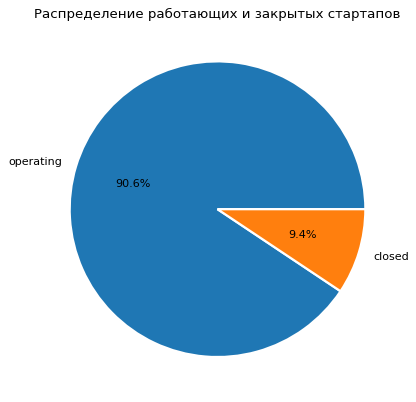

In [30]:
n1 = startups_train[startups_train['status'] == 'operating']['name'].count()
n2 = startups_train[startups_train['status'] == 'closed']['name'].count()
plt.figure(figsize=(10,6), dpi= 80)
plt.pie([n1, n2], labels=['operating', 'closed'], wedgeprops = { 'linewidth' : 2, 'edgecolor' : 'white'}, autopct='%.1f%%')
plt.title('Распределение работающих и закрытых стартапов')
plt.show()

Работающих стартапов значительно больше, чем закрытых. Налицо дисбалансс классов, что будет необходимо учесть в дальнейшем.

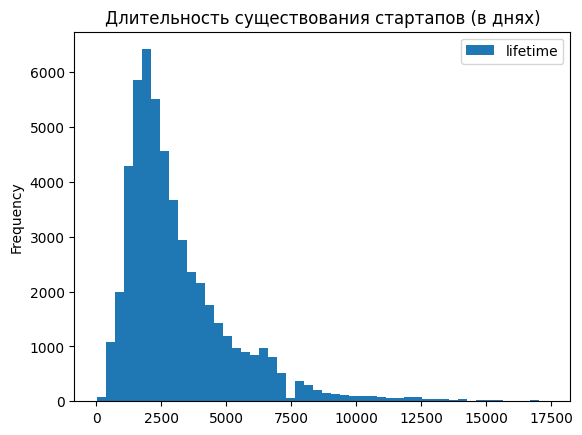

In [31]:
startups_train.plot(
kind='hist',
y='lifetime',
title='Длительность существования стартапов (в днях)',
bins=50,
)
plt.show()

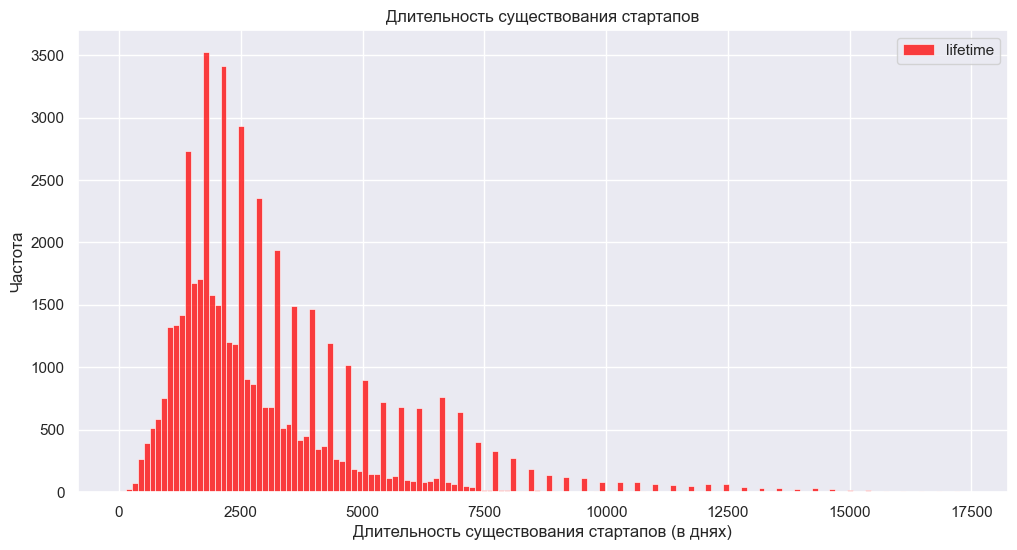

In [32]:
plt.figure(figsize=(12,6))
sns.set_theme(style="darkgrid")

sns.histplot(data=startups_train, x="lifetime", color="red", label="lifetime")

plt.ylabel('Частота')
plt.xlabel('Длительность существования стартапов (в днях)')
plt.title('Длительность существования стартапов')
plt.legend() 
plt.show()

Длительность существования стартапов - подозрительный признак. Если его значение мало, то это может означать, что стартап уже закрылся либо он открылся незадолго до выгрузки данных. В сочетании с датой основания стартапа он приведет к утечке данных. На графике видны периодические всплески с годовым интервалом, по-видимому, связанные как раз с закрытиями стартапов. Надо будет попробовать обучить модель с этим признаком и без него. 

In [33]:
startups_train_1 = startups_train.dropna(subset=['funding_total_usd']).reset_index(drop= True)

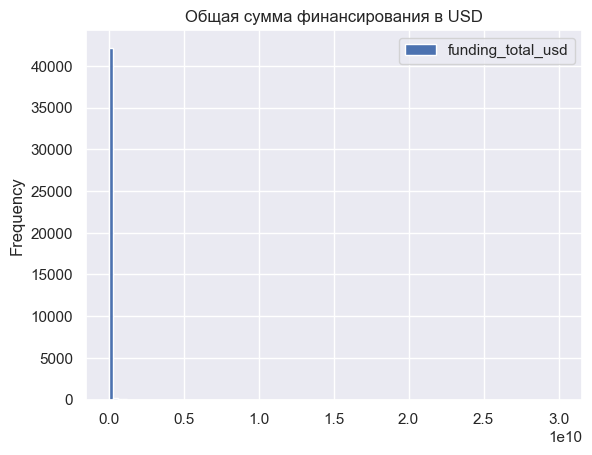

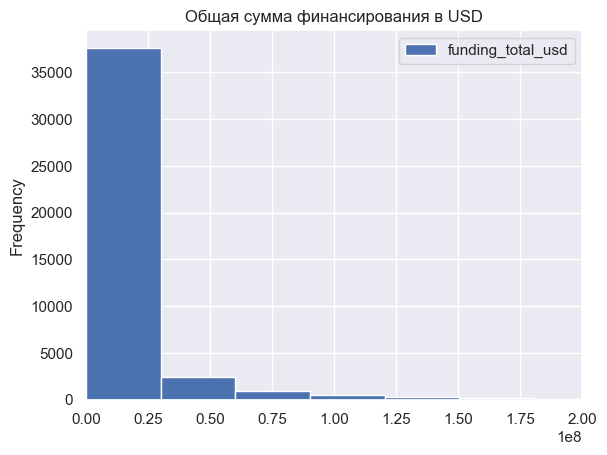

In [34]:
startups_train.plot(
kind='hist',
y='funding_total_usd',
title='Общая сумма финансирования в USD',
bins=100,
)
plt.show()
startups_train.plot(
kind='hist',
y='funding_total_usd',
title='Общая сумма финансирования в USD',
xlim=(0, 0.2e9),
bins=1000,
)
plt.show()

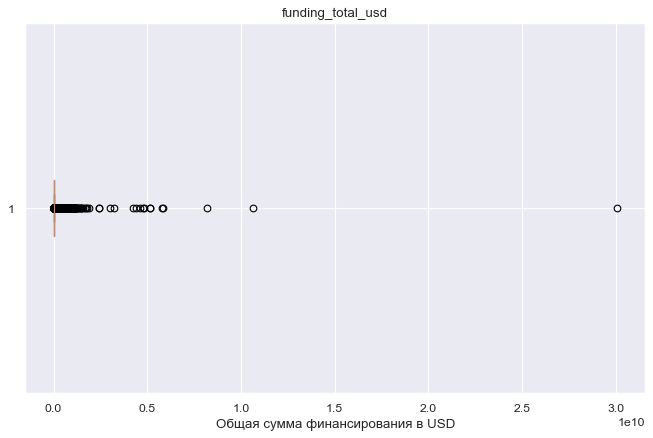

In [35]:
plt.figure(figsize=(10,6), dpi= 80)
plt.boxplot(startups_train_1['funding_total_usd'], vert=False)
plt.title('funding_total_usd')
plt.xlabel('Общая сумма финансирования в USD')
plt.show()

In [36]:
startups_train.query('funding_total_usd < 50')

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,lifetime,first_funding_at_year,last_funding_at_year
10219,Stirling Power,Design,29.0,operating,USA,ND,ND - Other,Michigan,1,5521,2004,2004
11022,Threatbutt,Animal Feed|Cyber Security|Data Security|Homel...,12.0,operating,USA,CA,SF Bay Area,Menlo Park,1,987,2015,2015
11404,Sentic Technologies Inc,Information Technology|Internet|SaaS|Search Ma...,1.0,operating,USA,IL,Chicago,Chicago,1,1430,2015,2015
27331,Soundctl,Audio|Video Streaming,2.0,operating,USA,CA,SF Bay Area,Mountain View,1,915,2015,2015
27770,The Manly Man Can,Fashion,30.0,operating,USA,MI,Detroit,Pinckney,1,1163,2014,2014
29014,Romo Wind,Innovation Engineering|Optimization|Services,5.0,operating,DEU,8,DEU - Other,Straße,1,2328,2013,2013
31999,Solvo,Information Technology|Services|Software,20.0,operating,CRI,4,Costa Rica,Heredia,1,1431,2015,2015
48686,Synergia Pharma,Pharmaceuticals,2.0,closed,USA,CA,SF Bay Area,San Francisco,1,1226,2003,2003
51353,Sight Diagnostics,Health Care,6.0,operating,ISR,6,Tel Aviv,Jerusalem,1,2557,2014,2014
51895,RN Entertainment,Media|Music|News,10.0,operating,USA,TN,Nashville,Nashville,1,1157,2015,2015


In [37]:
startups_train.query('funding_total_usd > 0.5e10')

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,lifetime,first_funding_at_year,last_funding_at_year
4556,Uber,Automotive|Design|Limousines|Public Transporta...,8.207450e+09,operating,USA,CA,SF Bay Area,San Francisco,13,3228,2009,2015
5286,Cambridge Technology Partners (CTP),Architecture|Banking|Finance,5.150000e+09,operating,NaN,NaN,NaN,NaN,2,10217,1995,2001
15975,Clearwire,Internet|Mobile,5.820000e+09,operating,USA,WA,Seattle,Kirkland,6,5206,2001,2013
21240,Cambridge Technology Group,Consulting|Product Development Services|Produc...,1.066494e+10,operating,NaN,NaN,NaN,NaN,1,10958,2000,2000
29079,Charter Communications,Internet|Telecommunications|Television|Video,5.162513e+09,operating,USA,CT,Hartford,Stamford,2,9131,2009,2014
36633,Sberbank,Banking|Finance,5.800000e+09,operating,RUS,48,Moscow,Moscow,1,1748,2014,2014
39185,Verizon Communications,Communications Infrastructure|Information Tech...,3.007950e+10,operating,USA,NY,New York City,New York,5,12505,2010,2014


Видно, что для этого признака (Общая сумма финансирования в USD) наблюдается очень большой разброс. От 1 доллара до 3е10. Причем, похоже, что маленькая сумма не указывает на то, что стартап закроется. А вот стартапы с очень большим финансированием, скорее всего не закроются. Из боксплота видно, что в данных имеются выбросы. Поскольку данные выбросы вполне могут иметь место в реальности, пока оставим их, как есть. 

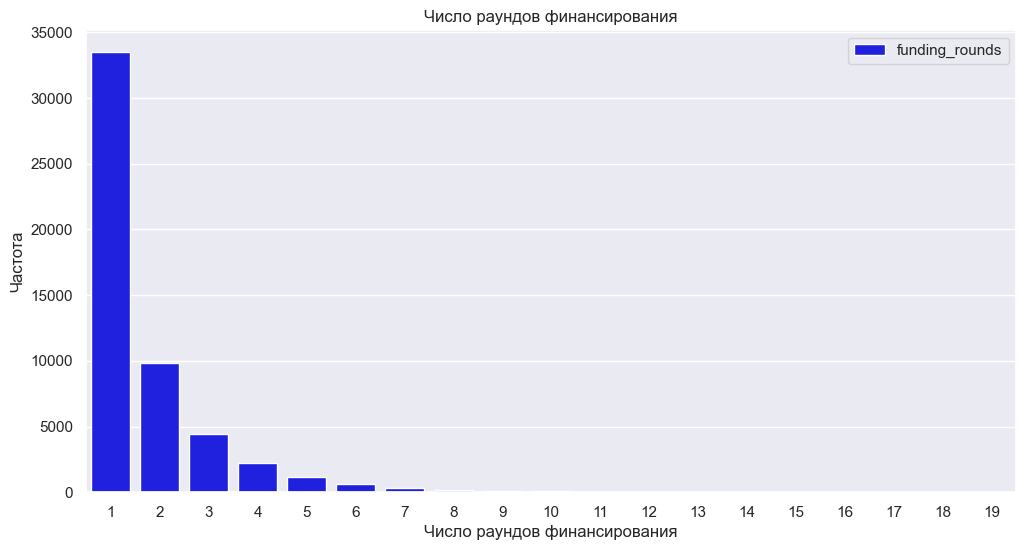

In [38]:
plt.figure(figsize=(12,6))
sns.set_theme(style="darkgrid")

sns.countplot(data=startups_train, x="funding_rounds", color="blue", label="funding_rounds")

plt.ylabel('Частота')
plt.xlabel('Число раундов финансирования')
plt.title('Число раундов финансирования')
plt.legend() 
plt.show()

Число раундов финансирования колеблется от 1 до 19. Причем большинство стартапов имеет только один раунд финансирования. Это, скорее всего, ничего не скажет нам о судьбе стартапа. А большое число раундов, наверное, говорит о хороших шансах выживания такого стартапа.

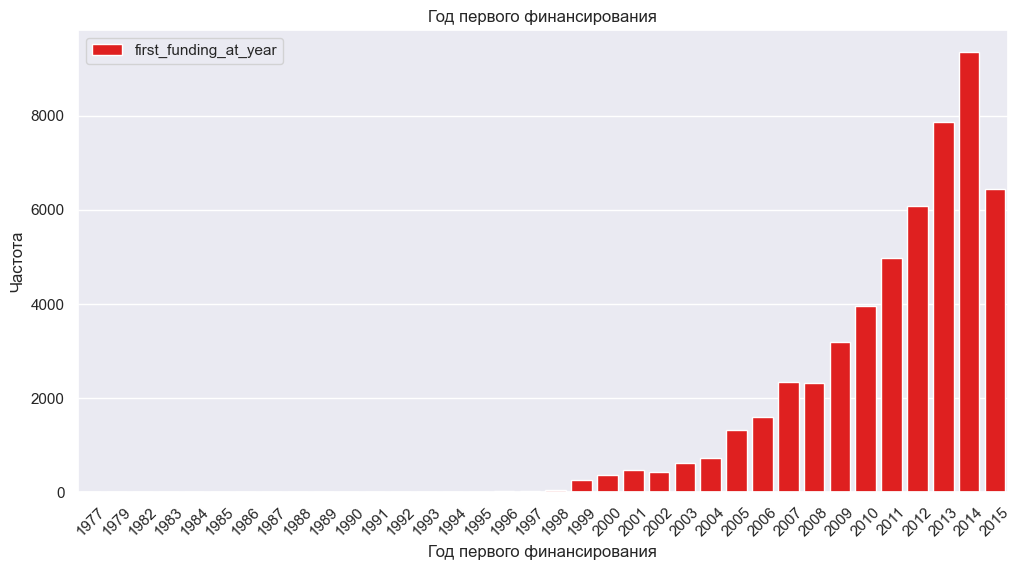

In [39]:
plt.figure(figsize=(12,6))
sns.set_theme(style="darkgrid")

sns.countplot(data=startups_train, x="first_funding_at_year", color="red", label="first_funding_at_year")
plt.xticks(rotation=45)
plt.ylabel('Частота')
plt.xlabel('Год первого финансирования')
plt.title('Год первого финансирования')
plt.legend() 
plt.show()

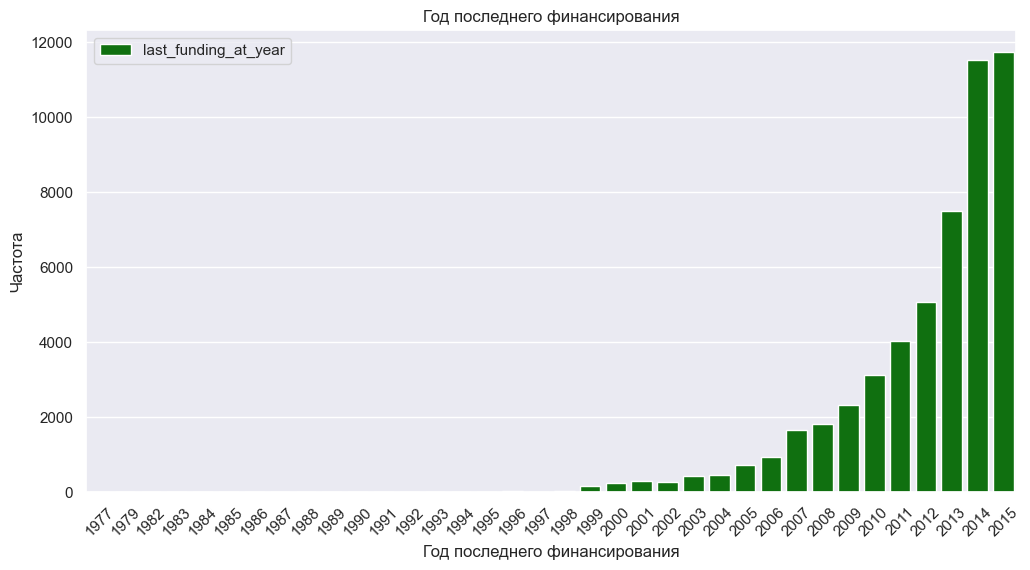

In [40]:
plt.figure(figsize=(12,6))
sns.set_theme(style="darkgrid")

sns.countplot(data=startups_train, x="last_funding_at_year", color="green", label="last_funding_at_year")
plt.xticks(rotation=45)
plt.ylabel('Частота')
plt.xlabel('Год последнего финансирования')
plt.title('Год последнего финансирования')
plt.legend() 
plt.show()

Из рассмотрения года первого и последнего финансирования видно, что в датасете преимущественно представлены стартапы, открывшиеся и финансировавшиеся после 2012 года.

<a id='4'></a>
## Корреляционный анализ

In [41]:
num_col = ['funding_total_usd', 'funding_rounds', 'lifetime', 'first_funding_at_year', 'last_funding_at_year']
cat_col = ['name', 'category_list', 'country_code', 'state_code', 'region', 'city', 'first_funding_at_year', 'last_funding_at_year']
interval = ['funding_total_usd', 'lifetime']

Для установления корреляций между целевым параметром - статусом стартапа (закрыт или действующий) и остальными признаками воспользуемся корреляцией Phi_K. Построим матрицу корреляций Phi_K.

In [42]:
startups_train_sample = startups_train.sample(n=10000)

In [43]:
startups_train_sample = startups_train_sample.drop('name', axis=1)

In [44]:
data_phik = startups_train_sample.phik_matrix(interval_cols = interval)
display(data_phik)

C:\Users\DAV.PC\anaconda3\envs\practicum\lib\site-packages\phik\data_quality.py:59: UserWarning: The number of unique values of variable category_list is large: 4788. Are you sure this is not an interval variable? Analysis for pairs of variables including category_list can be slow.
  warnings.warn(
C:\Users\DAV.PC\anaconda3\envs\practicum\lib\site-packages\phik\data_quality.py:59: UserWarning: The number of unique values of variable city is large: 1785. Are you sure this is not an interval variable? Analysis for pairs of variables including city can be slow.
  warnings.warn(


,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,lifetime,first_funding_at_year,last_funding_at_year
category_list,1.000000,0.992804,0.206225,0.988869,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
funding_total_usd,0.992804,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.632703,0.013565,0.000000,0.000000
status,0.206225,0.000000,1.000000,0.109027,0.117629,0.096500,0.000000,0.105433,0.553780,0.218513,0.260287
country_code,0.988869,0.000000,0.109027,1.000000,0.992509,0.999991,0.999992,0.000000,0.000000,0.000000,0.000000
state_code,0.000000,0.000000,0.117629,0.992509,1.000000,0.999913,0.999989,0.000000,0.295775,0.000000,0.000000
region,0.000000,0.000000,0.096500,0.999991,0.999913,1.000000,1.000000,0.000000,0.465441,0.000000,0.000000
city,0.000000,0.000000,0.000000,0.999992,0.999989,1.000000,1.000000,0.000000,0.755327,0.836831,0.799757
funding_rounds,0.000000,0.632703,0.105433,0.000000,0.000000,0.000000,0.000000,1.000000,0.216243,0.284983,0.078857
lifetime,0.000000,0.013565,0.553780,0.000000,0.295775,0.465441,0.755327,0.216243,1.000000,0.736728,0.652980
first_funding_at_year,0.000000,0.000000,0.218513,0.000000,0.000000,0.000000,0.836831,0.284983,0.736728,1.000000,0.996663


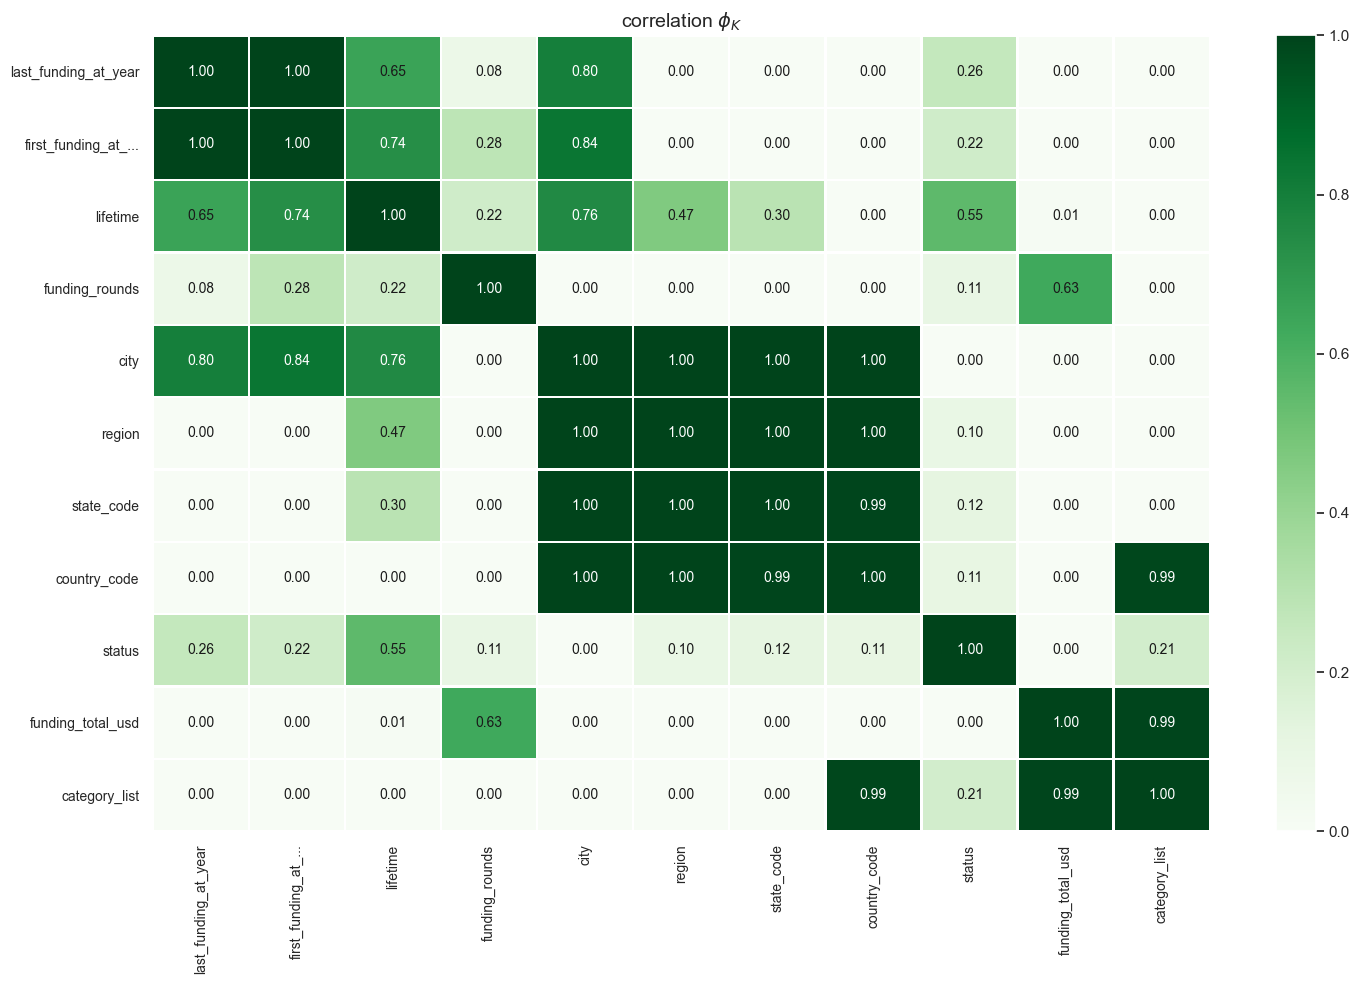

In [45]:
plot_correlation_matrix(data_phik.values, 
                        x_labels=data_phik.columns, 
                        y_labels=data_phik.index,
                        vmin=0, vmax=1, color_map="Greens", 
                        title=r"correlation $\phi_K$", 
                        fontsize_factor=1, 
                        figsize=(15, 10))

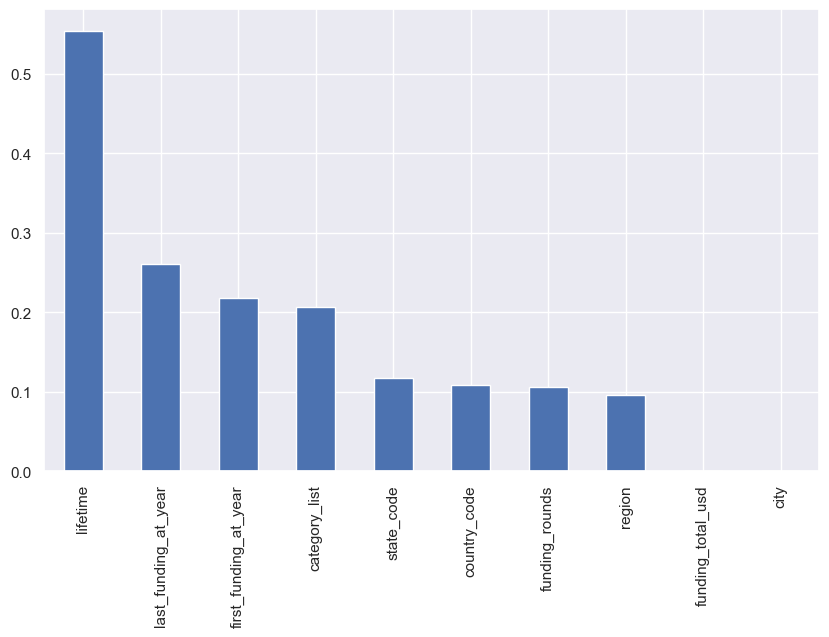

In [46]:
plt.figure(figsize=(10, 6))
_ = data_phik['status'].sort_values(ascending=False)[1:].plot(kind='bar')

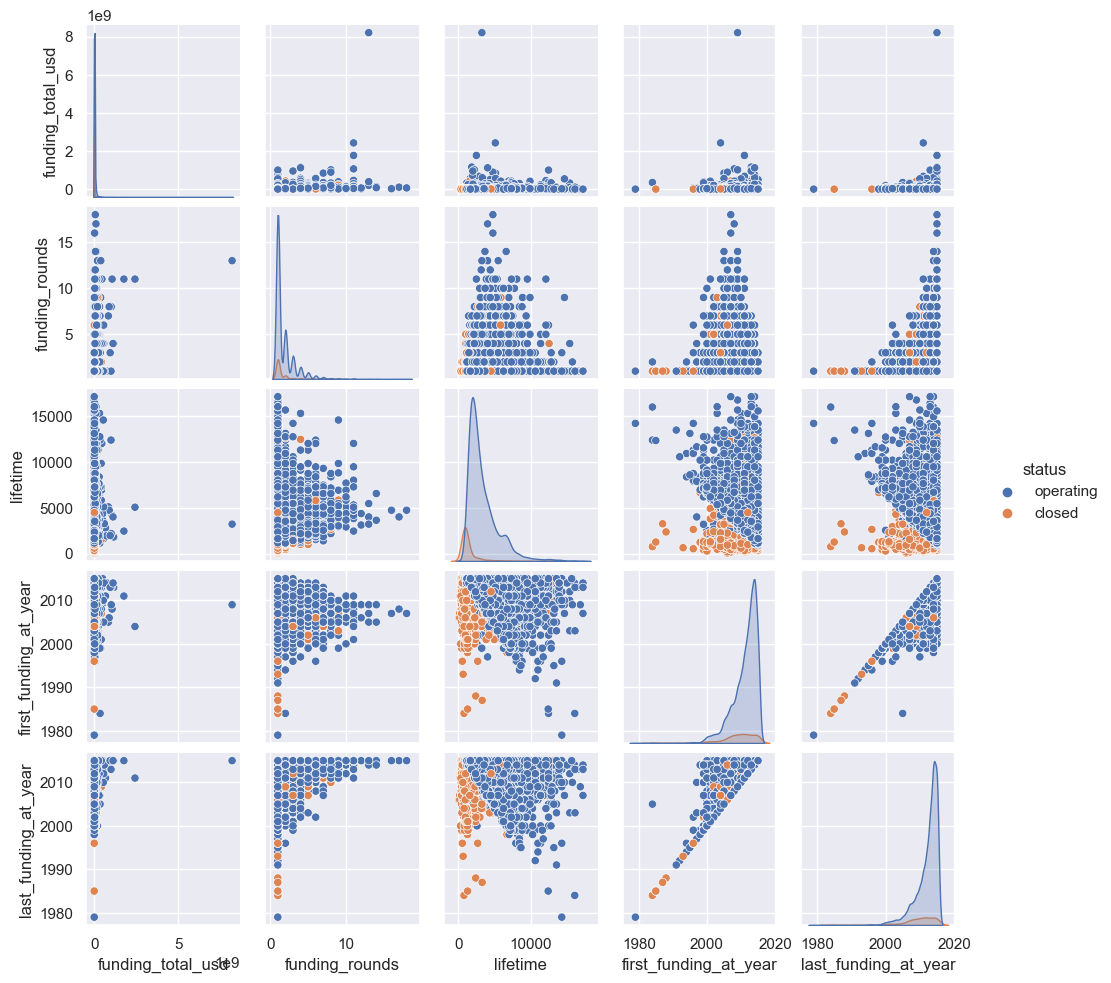

In [47]:
_ = sns.pairplot(startups_train_sample, hue='status', height=2)

Корреляционный анализ показывает, что целевой признак (ststus) лучше всего коррелирует с такимми признаками как category_list, lifetime. Он слабо коррелирует с параметрами first_funding_at_year и last_funding_at_year, между которыми наблюдается почти 100% корреляция. Поэтому для модели оставим только один из этих признаков. Также наблюдается слабая корреляция с признаками country_code, funding_total_usd и funding_rounds. Все признаки, относящиеся к географическому положению стартапа, имеют очень высокую корреляцию около 100% между собой (то есть, являются мультиколлинеарными). Возможно, не имеет смысла использовать все географические признаки для обучения модели.

<a id='5'></a>
## Обучение модели и использование пайплайнов

Закодируем целевой признак при помощи LabelEncoder().
Для подбора гиперпараметров моделей будем использовать GridSearchCV - метод поиска оптимальных значений параметров из заданного набора параметров в сетке .

Закодируем целевой признак. Разобьем датасет startups_train на тренировочную и тестовую выборки).

In [48]:
encoder = LabelEncoder()
Y = startups_train['status']

In [49]:
X_train, X_test, y_train, y_test = train_test_split(
startups_train.drop(
['status', 'name', 'first_funding_at_year', 'state_code', 'city'],
axis=1
),
Y,
test_size = TEST_SIZE,
random_state = RANDOM_STATE,
stratify = Y
)

In [50]:
y_train = encoder.fit_transform(y_train)
y_test = encoder.transform(y_test) 

In [51]:
display(X_train)

,category_list,funding_total_usd,country_code,region,funding_rounds,lifetime,last_funding_at_year
11764,Information Technology,107500.0,USA,Phoenix,1,2557,2014
49995,Health and Wellness,864500.0,USA,San Diego,1,2857,2011
1389,Software,20300000.0,USA,SF Bay Area,1,14245,2010
38496,Telecommunications,1575000.0,USA,Philadelphia,1,1327,2015
35556,Developer APIs|Software|Telecommunications|Uni...,1000000.0,USA,Chicago,1,3287,2014
...,...,...,...,...,...,...,...
44183,Security,34400000.0,USA,Boston,3,6209,2007
14942,Cloud Computing|Software,2000000.0,USA,SF Bay Area,1,1706,2014
28699,Analytics|Cloud Computing|Search,1510000.0,USA,Anaheim,4,2922,2013
15992,Biotechnology,649650.0,SWE,Malmo,1,2083,2012


In [52]:
num_col = ['funding_total_usd', 'funding_rounds', 'lifetime']
cat_col = ['region', 'last_funding_at_year', 'category_list', 'country_code']

Поскольку CatBoostClassifier отказался обрабатывать NaN в категориальных признаках, заменим их на строковую переменную.

In [53]:
X_train['region'] = X_train['region'].fillna('N')

In [54]:
X_train['country_code'] = X_train['country_code'].fillna('N')

In [55]:
X_train['category_list'] = X_train['category_list'].fillna('N')

In [56]:
X_test['region'] = X_test['region'].fillna('N')

In [57]:
X_test['category_list'] = X_test['category_list'].fillna('N')

In [58]:
X_test['country_code'] = X_test['country_code'].fillna('N')

In [59]:
display(X_test)

,category_list,funding_total_usd,country_code,region,funding_rounds,lifetime,last_funding_at_year
46173,B2B|Real Estate|Technology,392085.0,FRA,Paris,2,1270,2015
15566,Advertising|Brand Marketing|Content|Digital Me...,40000.0,ARG,Buenos Aires,1,2849,2012
11996,Business Intelligence|Curated Web|Data Mining|...,NaN,USA,New York City,1,3504,2010
35623,Advertising|Games|Location Based Services|Mobi...,1350000.0,USA,Dallas,2,2192,2012
11143,Apps|Internet|Technology,NaN,N,N,1,1025,2015
...,...,...,...,...,...,...,...
9605,Classifieds|Social Network Media,NaN,DNK,Copenhagen,3,1341,2015
12552,Travel & Tourism,680000.0,N,N,1,2922,2014
8889,Services,2785000.0,USA,Kansas City,1,2192,2015
12182,Consumer Electronics|Mobile Commerce|Online Sh...,NaN,USA,Greenville - Spartanburg,1,2802,2013


In [60]:
display(y_test)

array([1, 1, 1, ..., 1, 1, 1])

Поскольку датасет содержит большое число категориальных признаков с большим числом категорий, попробуем использовать в качестве обучающей модели CatBoostClassifier. На первом этапе не будем использовать pipeline и подбирать параметры модели.

In [61]:
model_cat = CatBoostClassifier(iterations=1000, learning_rate=0.1, depth=6, class_weights=[1, 10], cat_features = cat_col)

In [62]:
cat_features = cat_col

In [63]:
model_cat.fit(X_train, y_train)

0:	learn: 0.4878472	total: 199ms	remaining: 3m 18s
1:	learn: 0.3294411	total: 262ms	remaining: 2m 10s
2:	learn: 0.2274333	total: 309ms	remaining: 1m 42s
3:	learn: 0.1588094	total: 373ms	remaining: 1m 32s
4:	learn: 0.1278370	total: 394ms	remaining: 1m 18s
5:	learn: 0.1018534	total: 449ms	remaining: 1m 14s
6:	learn: 0.0840507	total: 488ms	remaining: 1m 9s
7:	learn: 0.0710993	total: 512ms	remaining: 1m 3s
8:	learn: 0.0606626	total: 583ms	remaining: 1m 4s
9:	learn: 0.0533466	total: 614ms	remaining: 1m
10:	learn: 0.0451236	total: 658ms	remaining: 59.2s
11:	learn: 0.0395197	total: 706ms	remaining: 58.1s
12:	learn: 0.0353913	total: 756ms	remaining: 57.4s
13:	learn: 0.0321546	total: 804ms	remaining: 56.6s
14:	learn: 0.0298770	total: 849ms	remaining: 55.8s
15:	learn: 0.0283012	total: 899ms	remaining: 55.3s
16:	learn: 0.0270158	total: 974ms	remaining: 56.3s
17:	learn: 0.0258495	total: 1.03s	remaining: 56s
18:	learn: 0.0249318	total: 1.08s	remaining: 55.6s
19:	learn: 0.0244527	total: 1.13s	remain

165:	learn: 0.0167609	total: 7.09s	remaining: 35.6s
166:	learn: 0.0167609	total: 7.12s	remaining: 35.5s
167:	learn: 0.0167609	total: 7.14s	remaining: 35.4s
168:	learn: 0.0167608	total: 7.17s	remaining: 35.3s
169:	learn: 0.0167608	total: 7.2s	remaining: 35.2s
170:	learn: 0.0167608	total: 7.23s	remaining: 35s
171:	learn: 0.0167608	total: 7.26s	remaining: 34.9s
172:	learn: 0.0167608	total: 7.29s	remaining: 34.9s
173:	learn: 0.0167608	total: 7.32s	remaining: 34.7s
174:	learn: 0.0167493	total: 7.35s	remaining: 34.7s
175:	learn: 0.0167492	total: 7.38s	remaining: 34.6s
176:	learn: 0.0167492	total: 7.41s	remaining: 34.5s
177:	learn: 0.0167492	total: 7.44s	remaining: 34.4s
178:	learn: 0.0167492	total: 7.47s	remaining: 34.3s
179:	learn: 0.0167492	total: 7.5s	remaining: 34.1s
180:	learn: 0.0167492	total: 7.52s	remaining: 34s
181:	learn: 0.0167492	total: 7.56s	remaining: 34s
182:	learn: 0.0167492	total: 7.59s	remaining: 33.9s
183:	learn: 0.0167492	total: 7.61s	remaining: 33.8s
184:	learn: 0.016749

324:	learn: 0.0166395	total: 12.1s	remaining: 25.1s
325:	learn: 0.0166395	total: 12.1s	remaining: 25s
326:	learn: 0.0166395	total: 12.1s	remaining: 25s
327:	learn: 0.0166395	total: 12.2s	remaining: 24.9s
328:	learn: 0.0166395	total: 12.2s	remaining: 24.9s
329:	learn: 0.0166395	total: 12.2s	remaining: 24.8s
330:	learn: 0.0166395	total: 12.3s	remaining: 24.8s
331:	learn: 0.0166395	total: 12.3s	remaining: 24.7s
332:	learn: 0.0166395	total: 12.3s	remaining: 24.6s
333:	learn: 0.0166395	total: 12.3s	remaining: 24.6s
334:	learn: 0.0166395	total: 12.4s	remaining: 24.6s
335:	learn: 0.0166395	total: 12.4s	remaining: 24.5s
336:	learn: 0.0166394	total: 12.4s	remaining: 24.5s
337:	learn: 0.0166394	total: 12.5s	remaining: 24.4s
338:	learn: 0.0166394	total: 12.5s	remaining: 24.3s
339:	learn: 0.0166394	total: 12.5s	remaining: 24.3s
340:	learn: 0.0166394	total: 12.6s	remaining: 24.3s
341:	learn: 0.0166394	total: 12.6s	remaining: 24.3s
342:	learn: 0.0166394	total: 12.7s	remaining: 24.2s
343:	learn: 0.01

485:	learn: 0.0166317	total: 17.2s	remaining: 18.2s
486:	learn: 0.0166317	total: 17.3s	remaining: 18.2s
487:	learn: 0.0166316	total: 17.3s	remaining: 18.2s
488:	learn: 0.0166316	total: 17.3s	remaining: 18.1s
489:	learn: 0.0166316	total: 17.4s	remaining: 18.1s
490:	learn: 0.0166316	total: 17.4s	remaining: 18s
491:	learn: 0.0166316	total: 17.4s	remaining: 18s
492:	learn: 0.0166316	total: 17.5s	remaining: 18s
493:	learn: 0.0166316	total: 17.5s	remaining: 17.9s
494:	learn: 0.0166316	total: 17.5s	remaining: 17.9s
495:	learn: 0.0166315	total: 17.6s	remaining: 17.8s
496:	learn: 0.0166315	total: 17.6s	remaining: 17.8s
497:	learn: 0.0166315	total: 17.6s	remaining: 17.7s
498:	learn: 0.0166315	total: 17.6s	remaining: 17.7s
499:	learn: 0.0166315	total: 17.7s	remaining: 17.7s
500:	learn: 0.0166315	total: 17.7s	remaining: 17.6s
501:	learn: 0.0166315	total: 17.7s	remaining: 17.6s
502:	learn: 0.0166315	total: 17.8s	remaining: 17.6s
503:	learn: 0.0166315	total: 17.8s	remaining: 17.5s
504:	learn: 0.0166

645:	learn: 0.0166135	total: 22.1s	remaining: 12.1s
646:	learn: 0.0166135	total: 22.2s	remaining: 12.1s
647:	learn: 0.0166135	total: 22.2s	remaining: 12.1s
648:	learn: 0.0166134	total: 22.3s	remaining: 12s
649:	learn: 0.0166134	total: 22.3s	remaining: 12s
650:	learn: 0.0166134	total: 22.3s	remaining: 12s
651:	learn: 0.0166134	total: 22.4s	remaining: 12s
652:	learn: 0.0166134	total: 22.5s	remaining: 11.9s
653:	learn: 0.0166134	total: 22.5s	remaining: 11.9s
654:	learn: 0.0166134	total: 22.6s	remaining: 11.9s
655:	learn: 0.0166134	total: 22.6s	remaining: 11.9s
656:	learn: 0.0166134	total: 22.6s	remaining: 11.8s
657:	learn: 0.0166134	total: 22.7s	remaining: 11.8s
658:	learn: 0.0166134	total: 22.7s	remaining: 11.8s
659:	learn: 0.0166134	total: 22.8s	remaining: 11.7s
660:	learn: 0.0166134	total: 22.8s	remaining: 11.7s
661:	learn: 0.0166134	total: 22.9s	remaining: 11.7s
662:	learn: 0.0166134	total: 22.9s	remaining: 11.7s
663:	learn: 0.0166134	total: 23s	remaining: 11.6s
664:	learn: 0.0166133	

805:	learn: 0.0165655	total: 27.4s	remaining: 6.59s
806:	learn: 0.0165655	total: 27.4s	remaining: 6.55s
807:	learn: 0.0165655	total: 27.4s	remaining: 6.52s
808:	learn: 0.0165655	total: 27.5s	remaining: 6.48s
809:	learn: 0.0165655	total: 27.5s	remaining: 6.45s
810:	learn: 0.0165654	total: 27.5s	remaining: 6.42s
811:	learn: 0.0165654	total: 27.6s	remaining: 6.38s
812:	learn: 0.0165654	total: 27.6s	remaining: 6.34s
813:	learn: 0.0165654	total: 27.6s	remaining: 6.31s
814:	learn: 0.0165654	total: 27.7s	remaining: 6.28s
815:	learn: 0.0165654	total: 27.7s	remaining: 6.24s
816:	learn: 0.0165653	total: 27.7s	remaining: 6.21s
817:	learn: 0.0165653	total: 27.8s	remaining: 6.18s
818:	learn: 0.0165653	total: 27.8s	remaining: 6.14s
819:	learn: 0.0165653	total: 27.8s	remaining: 6.11s
820:	learn: 0.0165653	total: 27.9s	remaining: 6.07s
821:	learn: 0.0165653	total: 27.9s	remaining: 6.04s
822:	learn: 0.0165653	total: 27.9s	remaining: 6s
823:	learn: 0.0165653	total: 27.9s	remaining: 5.97s
824:	learn: 0.0

965:	learn: 0.0165643	total: 32.4s	remaining: 1.14s
966:	learn: 0.0165643	total: 32.4s	remaining: 1.11s
967:	learn: 0.0165643	total: 32.5s	remaining: 1.07s
968:	learn: 0.0165643	total: 32.5s	remaining: 1.04s
969:	learn: 0.0165642	total: 32.5s	remaining: 1.01s
970:	learn: 0.0165642	total: 32.6s	remaining: 973ms
971:	learn: 0.0165642	total: 32.6s	remaining: 940ms
972:	learn: 0.0165642	total: 32.7s	remaining: 906ms
973:	learn: 0.0165642	total: 32.7s	remaining: 873ms
974:	learn: 0.0165642	total: 32.7s	remaining: 839ms
975:	learn: 0.0165642	total: 32.7s	remaining: 805ms
976:	learn: 0.0165642	total: 32.8s	remaining: 771ms
977:	learn: 0.0165642	total: 32.8s	remaining: 738ms
978:	learn: 0.0165641	total: 32.8s	remaining: 704ms
979:	learn: 0.0165641	total: 32.8s	remaining: 670ms
980:	learn: 0.0165641	total: 32.9s	remaining: 637ms
981:	learn: 0.0165641	total: 32.9s	remaining: 603ms
982:	learn: 0.0165641	total: 32.9s	remaining: 570ms
983:	learn: 0.0165641	total: 33s	remaining: 536ms
984:	learn: 0.

In [64]:
preds_cat = model_cat.predict(X_test)

In [65]:
display(preds_cat)

array([1, 1, 1, ..., 1, 1, 1], dtype=int64)

In [66]:
f1_cat = f1_score(y_test, preds_cat)

In [67]:
print('Метрика F1-Score на тестовой выборке', f1_cat)

Метрика F1-Score на тестовой выборке 0.9837395010136951


In [68]:
y_pred_cat_train = model_cat.predict(X_train)

In [69]:
f1_cat_train = f1_score(y_train, y_pred_cat_train)

In [70]:
print('Метрика модели на тренировочной выборке:', f1_cat_train)

Метрика модели на тренировочной выборке: 0.9840731394531088


Посчитаем предсказания на тестовом датасете startups_test.

In [71]:
test_cat = startups_test.drop(
['name', 'first_funding_at_year', 'state_code', 'city'],
axis=1
)

In [72]:
test_cat['country_code'] = test_cat['country_code'].fillna('N')

In [73]:
test_cat['region'] = test_cat['region'].fillna('N')

In [74]:
test_cat

,category_list,funding_total_usd,country_code,region,funding_rounds,lifetime,last_funding_at_year
0,Clean Technology,2819200.0,NIC,N,1,3501,2014
1,Hospitality,NaN,USA,TN - Other,1,2717,2014
2,Finance,428257.0,LUX,Esch-sur-alzette,2,1295,2014
3,Software|Video|Video Streaming,34700000.0,USA,San Diego,4,4748,2014
4,Software,4530000.0,CAN,Ottawa,1,6209,2012
...,...,...,...,...,...,...,...
13120,Recruiting,28000.0,USA,SF Bay Area,1,2267,2012
13121,Software,NaN,USA,SF Bay Area,1,2192,2014
13122,Design|E-Commerce|Marketplaces|Printing,5600000.0,USA,Seattle,3,2922,2015
13123,Advertising Exchanges|Mobile|Mobile Advertising,150000.0,USA,New York City,2,1386,2000


In [75]:
test_cat['category_list'] = test_cat['category_list'].fillna('N')

In [76]:
y_pred_cat_test = model_cat.predict(test_cat)

In [77]:
final_table_cat = startups_test.drop(
['funding_total_usd', 'first_funding_at_year', 'state_code', 'region', 'city', 'country_code', 'funding_rounds',
'lifetime', 'last_funding_at_year', 'category_list'],
axis=1
)

In [78]:
final_table_cat['status'] = y_pred_cat_test

In [79]:
final_table_cat['status'] = final_table_cat['status'].apply(lambda x: 'operating' if x == 1 else 'closed')

In [80]:
display(final_table_cat)

,name,status
0,Crystalsol,operating
1,JBI Fish & Wings,operating
2,COINPLUS,operating
3,Imagine Communications,operating
4,DNA13,operating
...,...,...
13120,Jymob,operating
13121,GlobaTrek,operating
13122,Inkd.com,operating
13123,AdWill,closed


In [81]:
display(final_table_cat[final_table_cat['status'] == 'closed']['status'].count())

1385

In [82]:
df0 = pd.DataFrame(final_table_cat)

In [83]:
df0.to_csv('output0.csv', index=False)

Попробуем использовать при обучении модели pipeline. Обработаем численные признаки при помощи StandardScaler() или MinMaxScaler(), указав их в качестве параметров. Для заполнения пропусков используем SimpleImputer.

In [84]:
X_train['last_funding_at_year'] = str(X_train['last_funding_at_year'])

In [85]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39386 entries, 11764 to 26380
Data columns (total 7 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   category_list         39386 non-null  object 
 1   funding_total_usd     31802 non-null  float64
 2   country_code          39386 non-null  object 
 3   region                39386 non-null  object 
 4   funding_rounds        39386 non-null  int64  
 5   lifetime              39386 non-null  int64  
 6   last_funding_at_year  39386 non-null  object 
dtypes: float64(1), int64(2), object(4)
memory usage: 2.4+ MB


In [86]:
# создаём пайплайн для подготовки признаков из списка cat_col: заполнение пропусков и OHE-кодирование
# SimpleImputer + OHE
ohe_pipe = Pipeline(
    [
        (
            'simpleImputer_ohe', 
            SimpleImputer(missing_values=np.nan, strategy='constant', fill_value='N')
        ),
        #(
            #'ohe', 
            #OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False)
        #)
    ]
)

In [87]:
num_pipe = Pipeline(
    [
        (
            'simpleImputer_num', 
            SimpleImputer(missing_values=np.nan, strategy='median')
        ),
        (
            'num', 
            StandardScaler()
        )
    ]
)

In [88]:
# создаём общий пайплайн для подготовки данных
data_preprocessor = ColumnTransformer(
    [
        ('ohe', ohe_pipe, cat_col),
        ('num', num_pipe, num_col)
    ], 
    remainder='passthrough',
    
)

In [89]:
# создаём итоговый пайплайн: подготовка данных и модель
# создаём итоговый пайплайн: подготовка данных и модель
pipe_final= Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('models', CatBoostClassifier(cat_features=[0, 1, 2, 3], iterations=1000, learning_rate=0.1, depth=6, class_weights=[1, 10]))
    ]
)

param_grid = [
    # словарь для модели CatBoostClassifier()
    {
        'models': [CatBoostClassifier(cat_features=[0, 1, 2, 3], random_state=RANDOM_STATE)],
        'models__depth': [6, 8],
        'models__iterations': [600, 700, 800],
        'models__learning_rate': np.arange(0.01, 0.1),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    
     # словарь для модели HistGradientBoostingClassifier()
   
    
    ]



В качестве метрики будем использовать метрику F1-Score. F1-мера вычисляется на основе точности p и полноты r. Точность - это отношение true positives (tp) ко всем predicted positives (tp + fp). Полнота это отношение true positives ко всем actual positives (tp + fn). Метрика F1 является гармоническим средним между Recall и Precision. Хорошая модель при обучении будет максимизировать Recall и Precision одновременно. Таким образом, умеренно хорошие показатели по обоим параметрам будут предпочтительнее, чем чрезвычайно хорошие показатели по одному и плохие по другому.

In [90]:
pipe_final.fit(X_train, y_train)

0:	learn: 0.4950918	total: 18ms	remaining: 18s
1:	learn: 0.3471428	total: 65.5ms	remaining: 32.7s
2:	learn: 0.2581454	total: 82.8ms	remaining: 27.5s
3:	learn: 0.1895221	total: 125ms	remaining: 31.1s
4:	learn: 0.1421019	total: 167ms	remaining: 33.2s
5:	learn: 0.1128554	total: 205ms	remaining: 34s
6:	learn: 0.0906925	total: 256ms	remaining: 36.3s
7:	learn: 0.0756823	total: 290ms	remaining: 35.9s
8:	learn: 0.0636242	total: 332ms	remaining: 36.6s
9:	learn: 0.0559388	total: 366ms	remaining: 36.2s
10:	learn: 0.0512732	total: 410ms	remaining: 36.9s
11:	learn: 0.0460942	total: 459ms	remaining: 37.8s
12:	learn: 0.0431804	total: 508ms	remaining: 38.6s
13:	learn: 0.0404945	total: 558ms	remaining: 39.3s
14:	learn: 0.0385459	total: 608ms	remaining: 39.9s
15:	learn: 0.0374288	total: 659ms	remaining: 40.6s
16:	learn: 0.0361846	total: 711ms	remaining: 41.1s
17:	learn: 0.0352809	total: 759ms	remaining: 41.4s
18:	learn: 0.0345127	total: 810ms	remaining: 41.8s
19:	learn: 0.0340298	total: 856ms	remaining:

161:	learn: 0.0284266	total: 6.36s	remaining: 32.9s
162:	learn: 0.0284266	total: 6.39s	remaining: 32.8s
163:	learn: 0.0284266	total: 6.42s	remaining: 32.7s
164:	learn: 0.0284265	total: 6.45s	remaining: 32.6s
165:	learn: 0.0284265	total: 6.47s	remaining: 32.5s
166:	learn: 0.0284265	total: 6.5s	remaining: 32.4s
167:	learn: 0.0284264	total: 6.53s	remaining: 32.3s
168:	learn: 0.0284264	total: 6.56s	remaining: 32.3s
169:	learn: 0.0284264	total: 6.59s	remaining: 32.2s
170:	learn: 0.0284264	total: 6.62s	remaining: 32.1s
171:	learn: 0.0284263	total: 6.65s	remaining: 32s
172:	learn: 0.0284263	total: 6.68s	remaining: 31.9s
173:	learn: 0.0284263	total: 6.71s	remaining: 31.8s
174:	learn: 0.0284263	total: 6.73s	remaining: 31.7s
175:	learn: 0.0284262	total: 6.76s	remaining: 31.7s
176:	learn: 0.0284262	total: 6.79s	remaining: 31.6s
177:	learn: 0.0284262	total: 6.82s	remaining: 31.5s
178:	learn: 0.0284262	total: 6.84s	remaining: 31.4s
179:	learn: 0.0284261	total: 6.87s	remaining: 31.3s
180:	learn: 0.0

326:	learn: 0.0283589	total: 11s	remaining: 22.7s
327:	learn: 0.0283589	total: 11.1s	remaining: 22.7s
328:	learn: 0.0283589	total: 11.1s	remaining: 22.6s
329:	learn: 0.0283587	total: 11.1s	remaining: 22.6s
330:	learn: 0.0283587	total: 11.2s	remaining: 22.6s
331:	learn: 0.0283551	total: 11.2s	remaining: 22.5s
332:	learn: 0.0282987	total: 11.3s	remaining: 22.6s
333:	learn: 0.0282694	total: 11.3s	remaining: 22.6s
334:	learn: 0.0282694	total: 11.3s	remaining: 22.5s
335:	learn: 0.0282492	total: 11.4s	remaining: 22.5s
336:	learn: 0.0282491	total: 11.4s	remaining: 22.5s
337:	learn: 0.0282491	total: 11.5s	remaining: 22.4s
338:	learn: 0.0282491	total: 11.5s	remaining: 22.4s
339:	learn: 0.0282491	total: 11.5s	remaining: 22.4s
340:	learn: 0.0282491	total: 11.5s	remaining: 22.3s
341:	learn: 0.0282491	total: 11.6s	remaining: 22.3s
342:	learn: 0.0282491	total: 11.6s	remaining: 22.2s
343:	learn: 0.0282491	total: 11.6s	remaining: 22.2s
344:	learn: 0.0282491	total: 11.7s	remaining: 22.1s
345:	learn: 0.

485:	learn: 0.0282170	total: 15.7s	remaining: 16.6s
486:	learn: 0.0282170	total: 15.7s	remaining: 16.5s
487:	learn: 0.0282170	total: 15.7s	remaining: 16.5s
488:	learn: 0.0282170	total: 15.7s	remaining: 16.5s
489:	learn: 0.0282169	total: 15.8s	remaining: 16.4s
490:	learn: 0.0282169	total: 15.8s	remaining: 16.4s
491:	learn: 0.0282168	total: 15.8s	remaining: 16.3s
492:	learn: 0.0282168	total: 15.9s	remaining: 16.3s
493:	learn: 0.0282168	total: 15.9s	remaining: 16.3s
494:	learn: 0.0282168	total: 15.9s	remaining: 16.2s
495:	learn: 0.0282168	total: 15.9s	remaining: 16.2s
496:	learn: 0.0282168	total: 16s	remaining: 16.2s
497:	learn: 0.0282168	total: 16s	remaining: 16.1s
498:	learn: 0.0282167	total: 16s	remaining: 16.1s
499:	learn: 0.0282167	total: 16s	remaining: 16s
500:	learn: 0.0282167	total: 16.1s	remaining: 16s
501:	learn: 0.0282166	total: 16.1s	remaining: 16s
502:	learn: 0.0282166	total: 16.1s	remaining: 15.9s
503:	learn: 0.0282166	total: 16.2s	remaining: 15.9s
504:	learn: 0.0282166	tota

645:	learn: 0.0281315	total: 20.1s	remaining: 11s
646:	learn: 0.0281314	total: 20.1s	remaining: 11s
647:	learn: 0.0281314	total: 20.1s	remaining: 10.9s
648:	learn: 0.0281314	total: 20.1s	remaining: 10.9s
649:	learn: 0.0281314	total: 20.2s	remaining: 10.9s
650:	learn: 0.0281314	total: 20.2s	remaining: 10.8s
651:	learn: 0.0281314	total: 20.2s	remaining: 10.8s
652:	learn: 0.0281313	total: 20.2s	remaining: 10.8s
653:	learn: 0.0281313	total: 20.3s	remaining: 10.7s
654:	learn: 0.0281312	total: 20.3s	remaining: 10.7s
655:	learn: 0.0281312	total: 20.3s	remaining: 10.7s
656:	learn: 0.0281312	total: 20.3s	remaining: 10.6s
657:	learn: 0.0281312	total: 20.4s	remaining: 10.6s
658:	learn: 0.0281311	total: 20.4s	remaining: 10.6s
659:	learn: 0.0281311	total: 20.4s	remaining: 10.5s
660:	learn: 0.0281311	total: 20.5s	remaining: 10.5s
661:	learn: 0.0281311	total: 20.5s	remaining: 10.5s
662:	learn: 0.0281311	total: 20.5s	remaining: 10.4s
663:	learn: 0.0281311	total: 20.5s	remaining: 10.4s
664:	learn: 0.02

806:	learn: 0.0281279	total: 24.4s	remaining: 5.84s
807:	learn: 0.0281279	total: 24.4s	remaining: 5.81s
808:	learn: 0.0281279	total: 24.5s	remaining: 5.78s
809:	learn: 0.0281278	total: 24.5s	remaining: 5.74s
810:	learn: 0.0281278	total: 24.5s	remaining: 5.71s
811:	learn: 0.0281278	total: 24.5s	remaining: 5.68s
812:	learn: 0.0281278	total: 24.6s	remaining: 5.65s
813:	learn: 0.0281278	total: 24.6s	remaining: 5.62s
814:	learn: 0.0281278	total: 24.6s	remaining: 5.59s
815:	learn: 0.0281278	total: 24.6s	remaining: 5.56s
816:	learn: 0.0281277	total: 24.7s	remaining: 5.53s
817:	learn: 0.0281277	total: 24.7s	remaining: 5.5s
818:	learn: 0.0281277	total: 24.7s	remaining: 5.46s
819:	learn: 0.0281276	total: 24.8s	remaining: 5.43s
820:	learn: 0.0281276	total: 24.8s	remaining: 5.4s
821:	learn: 0.0281276	total: 24.8s	remaining: 5.37s
822:	learn: 0.0281276	total: 24.8s	remaining: 5.34s
823:	learn: 0.0281276	total: 24.9s	remaining: 5.31s
824:	learn: 0.0281276	total: 24.9s	remaining: 5.28s
825:	learn: 0.

965:	learn: 0.0281245	total: 28.8s	remaining: 1.01s
966:	learn: 0.0281244	total: 28.8s	remaining: 983ms
967:	learn: 0.0281243	total: 28.8s	remaining: 953ms
968:	learn: 0.0281243	total: 28.9s	remaining: 924ms
969:	learn: 0.0281243	total: 28.9s	remaining: 894ms
970:	learn: 0.0281243	total: 28.9s	remaining: 864ms
971:	learn: 0.0281243	total: 29s	remaining: 835ms
972:	learn: 0.0281243	total: 29s	remaining: 805ms
973:	learn: 0.0281243	total: 29s	remaining: 775ms
974:	learn: 0.0281243	total: 29.1s	remaining: 745ms
975:	learn: 0.0281242	total: 29.1s	remaining: 715ms
976:	learn: 0.0281242	total: 29.1s	remaining: 685ms
977:	learn: 0.0281242	total: 29.1s	remaining: 656ms
978:	learn: 0.0281241	total: 29.2s	remaining: 626ms
979:	learn: 0.0281241	total: 29.2s	remaining: 596ms
980:	learn: 0.0281241	total: 29.2s	remaining: 566ms
981:	learn: 0.0281241	total: 29.3s	remaining: 536ms
982:	learn: 0.0281241	total: 29.3s	remaining: 507ms
983:	learn: 0.0281241	total: 29.3s	remaining: 477ms
984:	learn: 0.0281

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(fill_value='N',
                                                                                 strategy='constant'))]),
                                                  ['region',
                                                   'last_funding_at_year',
                                                   'category_list',
                                                   'country_code']),
                                                 ('num',
                                                  Pipeline(steps=[('simpleImputer_num',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('num',
                                                                   StandardScaler())]),
                                                  ['funding_total_usd',
                                                   'funding_rounds',
                                                   'lifetime'])])),
                ('models',
                 <catboost.core.CatBoostClassifier object at 0x0000020573D6A6D0>)])

In [91]:
preds = pipe_final.predict(X_test)

In [92]:
display(preds)

array([1, 1, 1, ..., 1, 1, 1], dtype=int64)

In [93]:
f1 = f1_score(y_test, preds)

In [94]:
print('Метрика F1-Score', f1)

Метрика F1-Score 0.9695857795172863


In [95]:
grid = GridSearchCV(
    pipe_final, 
    param_grid=param_grid, 
    cv=3, 
    scoring='f1', 
    n_jobs=-1
)

In [96]:
grid.fit(X_train, y_train)

# выведите параметры лучшей модели
print('Лучшая модель и её параметры:\n\n', grid.best_estimator_)

0:	learn: 0.6783143	total: 61.9ms	remaining: 49.4s
1:	learn: 0.6642470	total: 91.4ms	remaining: 36.5s
2:	learn: 0.6514542	total: 139ms	remaining: 36.9s
3:	learn: 0.6375994	total: 184ms	remaining: 36.6s
4:	learn: 0.6239357	total: 233ms	remaining: 37.1s
5:	learn: 0.6103015	total: 290ms	remaining: 38.4s
6:	learn: 0.5967134	total: 358ms	remaining: 40.6s
7:	learn: 0.5859491	total: 385ms	remaining: 38.1s
8:	learn: 0.5737110	total: 439ms	remaining: 38.6s
9:	learn: 0.5618841	total: 490ms	remaining: 38.7s
10:	learn: 0.5499241	total: 550ms	remaining: 39.4s
11:	learn: 0.5397649	total: 576ms	remaining: 37.8s
12:	learn: 0.5283477	total: 622ms	remaining: 37.7s
13:	learn: 0.5177416	total: 678ms	remaining: 38.1s
14:	learn: 0.5071159	total: 734ms	remaining: 38.4s
15:	learn: 0.4968914	total: 779ms	remaining: 38.2s
16:	learn: 0.4870708	total: 838ms	remaining: 38.6s
17:	learn: 0.4778453	total: 901ms	remaining: 39.2s
18:	learn: 0.4692160	total: 934ms	remaining: 38.4s
19:	learn: 0.4617218	total: 965ms	remai

162:	learn: 0.1653468	total: 8.76s	remaining: 34.2s
163:	learn: 0.1649752	total: 8.82s	remaining: 34.2s
164:	learn: 0.1646217	total: 8.88s	remaining: 34.2s
165:	learn: 0.1643339	total: 8.94s	remaining: 34.1s
166:	learn: 0.1639756	total: 9s	remaining: 34.1s
167:	learn: 0.1636460	total: 9.05s	remaining: 34.1s
168:	learn: 0.1633056	total: 9.12s	remaining: 34s
169:	learn: 0.1629843	total: 9.17s	remaining: 34s
170:	learn: 0.1626885	total: 9.23s	remaining: 34s
171:	learn: 0.1623990	total: 9.29s	remaining: 33.9s
172:	learn: 0.1620647	total: 9.35s	remaining: 33.9s
173:	learn: 0.1617642	total: 9.42s	remaining: 33.9s
174:	learn: 0.1614610	total: 9.47s	remaining: 33.8s
175:	learn: 0.1611806	total: 9.53s	remaining: 33.8s
176:	learn: 0.1608905	total: 9.59s	remaining: 33.8s
177:	learn: 0.1606275	total: 9.64s	remaining: 33.7s
178:	learn: 0.1603235	total: 9.71s	remaining: 33.7s
179:	learn: 0.1600966	total: 9.77s	remaining: 33.6s
180:	learn: 0.1598425	total: 9.83s	remaining: 33.6s
181:	learn: 0.1596179

321:	learn: 0.1437109	total: 18.5s	remaining: 27.5s
322:	learn: 0.1436614	total: 18.6s	remaining: 27.5s
323:	learn: 0.1435897	total: 18.7s	remaining: 27.4s
324:	learn: 0.1435459	total: 18.7s	remaining: 27.4s
325:	learn: 0.1434894	total: 18.8s	remaining: 27.3s
326:	learn: 0.1434193	total: 18.8s	remaining: 27.3s
327:	learn: 0.1433499	total: 18.9s	remaining: 27.2s
328:	learn: 0.1433069	total: 19s	remaining: 27.2s
329:	learn: 0.1432628	total: 19s	remaining: 27.1s
330:	learn: 0.1432246	total: 19.1s	remaining: 27.1s
331:	learn: 0.1431726	total: 19.2s	remaining: 27s
332:	learn: 0.1431121	total: 19.3s	remaining: 27s
333:	learn: 0.1430696	total: 19.3s	remaining: 27s
334:	learn: 0.1430234	total: 19.4s	remaining: 26.9s
335:	learn: 0.1429657	total: 19.5s	remaining: 26.9s
336:	learn: 0.1429359	total: 19.5s	remaining: 26.8s
337:	learn: 0.1428835	total: 19.6s	remaining: 26.8s
338:	learn: 0.1428441	total: 19.7s	remaining: 26.8s
339:	learn: 0.1427915	total: 19.7s	remaining: 26.7s
340:	learn: 0.1427294	

480:	learn: 0.1380483	total: 28s	remaining: 18.6s
481:	learn: 0.1380189	total: 28s	remaining: 18.5s
482:	learn: 0.1380065	total: 28.1s	remaining: 18.4s
483:	learn: 0.1379789	total: 28.2s	remaining: 18.4s
484:	learn: 0.1379467	total: 28.2s	remaining: 18.3s
485:	learn: 0.1379152	total: 28.3s	remaining: 18.3s
486:	learn: 0.1378667	total: 28.3s	remaining: 18.2s
487:	learn: 0.1378464	total: 28.4s	remaining: 18.2s
488:	learn: 0.1378151	total: 28.5s	remaining: 18.1s
489:	learn: 0.1377914	total: 28.5s	remaining: 18.1s
490:	learn: 0.1377564	total: 28.6s	remaining: 18s
491:	learn: 0.1377262	total: 28.7s	remaining: 17.9s
492:	learn: 0.1377147	total: 28.7s	remaining: 17.9s
493:	learn: 0.1376784	total: 28.8s	remaining: 17.8s
494:	learn: 0.1376557	total: 28.8s	remaining: 17.8s
495:	learn: 0.1376296	total: 28.9s	remaining: 17.7s
496:	learn: 0.1376001	total: 29s	remaining: 17.7s
497:	learn: 0.1375863	total: 29s	remaining: 17.6s
498:	learn: 0.1375708	total: 29.1s	remaining: 17.6s
499:	learn: 0.1375406	

639:	learn: 0.1344909	total: 37.4s	remaining: 9.34s
640:	learn: 0.1344750	total: 37.4s	remaining: 9.29s
641:	learn: 0.1344388	total: 37.5s	remaining: 9.23s
642:	learn: 0.1344223	total: 37.6s	remaining: 9.17s
643:	learn: 0.1344171	total: 37.6s	remaining: 9.11s
644:	learn: 0.1344097	total: 37.7s	remaining: 9.05s
645:	learn: 0.1343939	total: 37.8s	remaining: 9s
646:	learn: 0.1343744	total: 37.8s	remaining: 8.94s
647:	learn: 0.1343526	total: 37.9s	remaining: 8.88s
648:	learn: 0.1343343	total: 37.9s	remaining: 8.82s
649:	learn: 0.1343101	total: 38s	remaining: 8.76s
650:	learn: 0.1343007	total: 38s	remaining: 8.71s
651:	learn: 0.1342819	total: 38.1s	remaining: 8.65s
652:	learn: 0.1342484	total: 38.2s	remaining: 8.59s
653:	learn: 0.1342129	total: 38.2s	remaining: 8.53s
654:	learn: 0.1341894	total: 38.3s	remaining: 8.48s
655:	learn: 0.1341570	total: 38.4s	remaining: 8.42s
656:	learn: 0.1341448	total: 38.4s	remaining: 8.36s
657:	learn: 0.1341212	total: 38.5s	remaining: 8.3s
658:	learn: 0.134097

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(fill_value='N',
                                                                                 strategy='constant'))]),
                                                  ['region',
                                                   'last_funding_at_year',
                                                   'category_list',
                                                   'country_code']),
                                                 ('num', StandardScaler(),
                                                  ['funding_total_usd',
                                                   'funding_rounds',
                                      

In [97]:
print ('Метрика лучшей модели на кросс-валидации:', grid.best_score_)

Метрика лучшей модели на кросс-валидации: 0.9753687999758975


In [98]:
best_model = grid.best_estimator_

In [99]:
print(grid.best_params_)

{'models': <catboost.core.CatBoostClassifier object at 0x0000020573D6A8E0>, 'models__depth': 8, 'models__iterations': 800, 'models__learning_rate': 0.01, 'preprocessor__num': StandardScaler()}


In [100]:
test = startups_test.drop(
['name', 'first_funding_at_year', 'state_code', 'city'],
axis=1
)

In [101]:
y_pred = best_model.predict(X_train)

In [102]:
f1_1 = f1_score(y_train, y_pred)

In [103]:
print('Метрика лучшей модели на тренировочной выборке:', f1_1)

Метрика лучшей модели на тренировочной выборке: 0.9776361353696728


In [104]:
y_pred_test = best_model.predict(test)

In [105]:
display(y_pred_test)

array([1, 1, 1, ..., 1, 1, 1], dtype=int64)

Параметры лучшей модели получились следующие: 'models__depth': 8, 'models__iterations': 800, 'models__learning_rate': 0.01, 'preprocessor__num': StandardScaler(). Метрика f1 на кросс-валидации - 0.975.

<a id='6'></a>
## Итоговая таблица с предсказаниями

In [106]:
final_table = startups_test.drop(
['funding_total_usd', 'first_funding_at_year', 'category_list', 'state_code', 'region', 'city', 'country_code', 'funding_rounds',
'lifetime', 'last_funding_at_year'],
axis=1
)

In [107]:
final_table['status'] = y_pred_test

In [108]:
display(final_table)

,name,status
0,Crystalsol,1
1,JBI Fish & Wings,1
2,COINPLUS,1
3,Imagine Communications,1
4,DNA13,1
...,...,...
13120,Jymob,1
13121,GlobaTrek,1
13122,Inkd.com,1
13123,AdWill,1


In [109]:
final_table['status'] = final_table['status'].apply(lambda x: 'operating' if x == 1 else 'closed')

In [110]:
display(final_table)

,name,status
0,Crystalsol,operating
1,JBI Fish & Wings,operating
2,COINPLUS,operating
3,Imagine Communications,operating
4,DNA13,operating
...,...,...
13120,Jymob,operating
13121,GlobaTrek,operating
13122,Inkd.com,operating
13123,AdWill,operating


In [111]:
display(final_table[final_table['status'] == 'closed']['status'].count())

923

In [112]:
df = pd.DataFrame(final_table)

In [113]:
df.to_csv('output.csv', index=False)

<a id='7'></a>
## Важность признаков

In [114]:
model = grid.best_estimator_.named_steps['models']

In [115]:
from catboost import cv, Pool
prep = grid.best_estimator_.named_steps['preprocessor']

In [116]:
col_names = prep.get_feature_names_out().tolist()

In [117]:
X_train_pre = prep.transform(X_train)

In [118]:
data_pool = Pool(X_train_pre, cat_features=[0, 1, 2, 3])


In [119]:
col_names

['ohe__region',
 'ohe__last_funding_at_year',
 'ohe__category_list',
 'ohe__country_code',
 'num__funding_total_usd',
 'num__funding_rounds',
 'num__lifetime']

In [120]:
X_train_pre_df = pd.DataFrame(X_train_pre, columns=col_names)

In [121]:
model.get_feature_importance(prettified=True)

,Feature Id,Importances
0,6,46.655821
1,4,16.494716
2,2,16.001245
3,3,9.262147
4,0,6.749103
5,5,4.836969
6,1,0.000000


In [122]:
shap_values = model.get_feature_importance(data_pool, type="ShapValues")

In [123]:
expected_value = shap_values[0,-1]
shap_values = shap_values[:,:-1]

print(shap_values.shape)

(39386, 7)


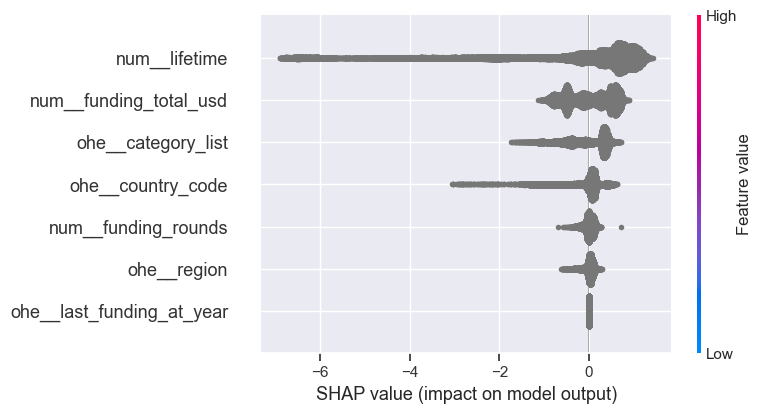

In [124]:
shap.summary_plot(shap_values, X_train_pre_df)

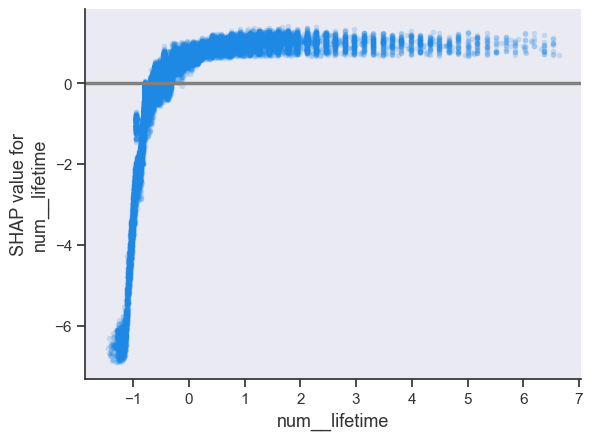

In [125]:
fig, ax = plt.subplots();
ax.grid();
plt.axhline(y=0, color='grey', linewidth=2.5);
shap.dependence_plot('num__lifetime', shap_values, X_train_pre_df, interaction_index=None, alpha=0.2, ax=ax);

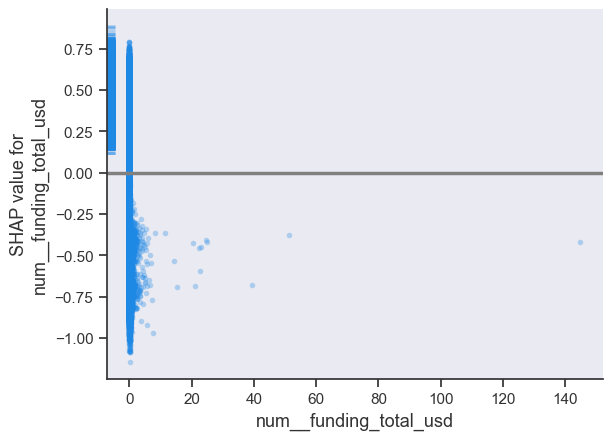

In [126]:
fig, ax = plt.subplots();
ax.grid();
plt.axhline(y=0, color='grey', linewidth=2.5);
shap.dependence_plot('num__funding_total_usd', shap_values, X_train_pre_df, interaction_index=None, alpha=0.3, ax=ax);

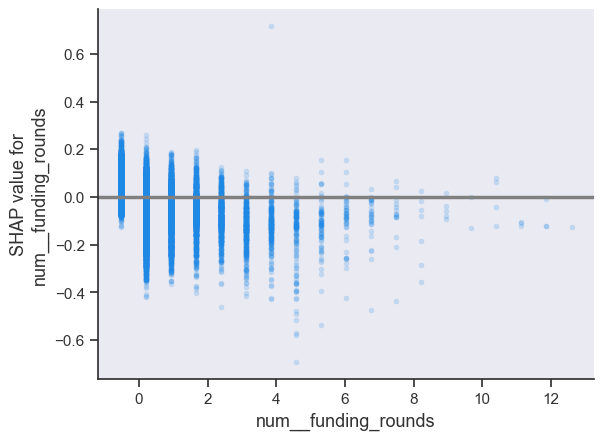

In [127]:
fig, ax = plt.subplots();
ax.grid();
plt.axhline(y=0, color='grey', linewidth=2.5);
shap.dependence_plot('num__funding_rounds', shap_values, X_train_pre_df, interaction_index=None, alpha=0.2, ax=ax);

Анализ важности признаков показывает, что с большим отрывом лидирует признак lifetime. Что собственно и ожидалось на этапе построения корреляционной матрицы. Слишком низкие значения этого параметра склоняют модель к тому, чтобы отнести объекты к классу 0 (то есть, closed). Из графика shap(lifetime) видно, что значение shap в области низких значений растет очень круто, почти вертикально. То есть, стартапы с очень коротким временем жизни (с очень небольшим разбросом по времени) будут отнесены к классу 0. Большая часть стартапов с чуть более длинным временем жизни уже будут отнесены к классу 1 (operating).  Поэтому я все-таки не выкинула этот признак.

Тем не менее, может возникнуть ситуация, когда модель была обучена на данных для стартапов с временами жизни, находящимися в широком диапазоне, а тестироваться на только что созданных стартапах с очень короткими временами жизни. В таком случае модель будет плохо справляться с предсказаниями. Так что, возможно, что этот признак все-таки надо было выкинуть.

Следующие по важности признаки: funding_total_usd и category_list.
Если я правильно интерпретирую графики зависимости значения shap от признаков funding_total_usd и funding_rounds, то выходит, что наличие очень высокого финансирования и большого числа раундов финанисирования склоняет модель к тому, чтобы отнести объекты к классу 0 (то есть, closed). Что выглядит как-то нелогично.

Наименее важними признаками оказались country_code, funding_rounds и region.





<a id='8'></a>
## Выводы

Постановка задачи.

Наша задача - разработать модель для предсказания успешности стартапа (закроется или нет).

Предоставлены следующие данные.

Данные Датасет состоит из двух файлов: тренировочный набор (около 53к записей) и тестовый набор (около 13к записей).

Тренировочный набор содержит целевой признак status, указывающий на то, закрылся стартап или продолжает действовать.

Временной период - '1970-01-01' по '2018-01-01'. Дата формирования выгрузки - '2018-01-01'

kaggle_startups_train_01.csv - информация (53 000) стартапах, которые будут использоваться в качестве обучающих данных.

kaggle_startups_test_01.csv - информация (13 000) стартапах, которые будут использоваться в качестве тестовых данных.

Наша задача - предсказать значение 'status' для каждого стартапа из этого датасета.

kaggle_startups_sample_submit_01.csv - файл с примером предсказаний в правильном формате.

name - идентификатор (название) стартапа в тестовом наборе.

status - целевой признак. Для каждого стартапа предскажите категориальное значение соответствующее прогнозу ['operating', 'closed'].

Описание полей данных

name - Название стартапа

category_list - Список категорий, к которым относится стартап

funding_total_usd - Общая сумма финансирования в USD

status - Статус стартапа (закрыт или действующий)

country_code - Код страны

state_code - Код штата

region - Регион
city - Город

funding_rounds - Количество раундов финансирования

founded_at - Дата основания

first_funding_at - Дата первого раунда финансирования

last_funding_at - Дата последнего раунда финансирования

closed_at - Дата закрытия стартапа (если применимо)

lifetime - Время существования стартапа в днях


В некотрых полях датасета kaggle_startups_train присутствует до 20% пропусков, которые невозможно заполнить искусственно, а выбрасывать такое количество данных нельзя. Поэтому оставим, как есть.
Также можно заметить, что в тестовых данных присутствует время существования стартапа в днях (lifetime). Этого поля нет в тренировочных данных, но его можно восстановить, воспользовавшись данными из столбцов founded_at, closed_at и даты выгрузки данных.
Строки, в которых нет имени стартапа, были удалены.

Поле со списком категорий содержит более 22 тыс. строк. По логике кажется, что этот параметр должен быть важен при определении судьбы стратапа. В связи с этим использовать OneHotEncoder и линейные модели - плохая идея. Скорее всего, для решения этой задачи подойдут бустинги. Попробуем использовать CatBoost, которому можно напрямую передавать категориальные данные.

Работающих стартапов значительно больше, чем закрытых. Налицо дисбалансс классов, что будет необходимо учесть в дальнейшем.

Длительность существования стартапов - подозрительный признак. Если его значение мало, то это может означать, что стартап уже закрылся либо он открылся незадолго до выгрузки данных. В сочетании с датой основания стартапа он приведет к утечке данных. На графике видны периодические всплески с годовым интервалом, по-видимому, связанные как раз с закрытиями стартапов. Надо будет попробовать обучить модель с этим признаком и без него.

Видно, что для признака (Общая сумма финансирования в USD) наблюдается очень большой разброс. От 1 доллара до 3е10. Причем, похоже, что маленькая сумма не указывает на то, что стартап закроется. А вот стартапы с очень большим финансированием, скорее всего не закроются. Из боксплота видно, что в данных имеются выбросы. Поскольку данные выбросы вполне могут иметь место в реальности, пока оставим их, как есть.

Число раундов финансирования колеблется от 1 до 19. Причем большинство стартапов имеет только один раунд финансирования. Это, скорее всего, ничего не скажет нам о судьбе стартапа. А большое число раундов, наверное, говорит о хороших шансах выживания такого стартапа.

Из рассмотрения года первого и последнего финансирования видно, что в датасете преимущественно представлены стартапы, открывшиеся и финансировавшиеся после 2012 года.



Для установления корреляций между целевым параметром - статусом стартапа (закрыт или действующий) и остальными признаками воспользуемся корреляцией Phi_K.

Корреляционный анализ показывает, что целевой признак (ststus) лучше всего коррелирует с такими признаками как category_list, lifetime. Он слабо коррелирует с параметрами first_funding_at_year и last_funding_at_year, между которыми наблюдается почти 100% корреляция. Поэтому для модели оставим только один из этих признаков. Также наблюдается слабая корреляция с признаками country_code, funding_total_usd и funding_rounds. Все признаки, относящиеся к географическому положению стартапа, имеют очень высокую корреляцию около 100% между собой (то есть, являются мультиколлинеарными). Возможно, не имеет смысла использовать все географические признаки для обучения модели.


Закодируем целевой признак при помощи LabelEncoder(). Для подбора гиперпараметров моделей будем использовать GridSearchCV - метод поиска оптимальных значений параметров из заданного набора параметров в сетке .

Поскольку датасет содержит большое число категориальных признаков с большим числом категорий, попробуем использовать в качестве обучающей модели CatBoostClassifier. На первом этапе не будем использовать pipeline и подбирать параметры модели.

На втором этапе попробуем использовать при обучении модели pipeline. Обработаем численные признаки при помощи StandardScaler() или MinMaxScaler(), указав их в качестве параметров. Для заполнения пропусков используем SimpleImputer.

В качестве метрики будем использовать метрику F1-Score. F1-мера вычисляется на основе точности p и полноты r. Точность - это отношение true positives (tp) ко всем predicted positives (tp + fp). Полнота это отношение true positives ко всем actual positives (tp + fn). Метрика F1 является гармоническим средним между Recall и Precision. Хорошая модель при обучении будет максимизировать Recall и Precision одновременно. Таким образом, умеренно хорошие показатели по обоим параметрам будут предпочтительнее, чем чрезвычайно хорошие показатели по одному и плохие по другому.


Параметры лучшей модели получились следующие: 'models__depth': 8, 'models__iterations': 800, 'models__learning_rate': 0.01, 'preprocessor__num': StandardScaler(). Метрика f1 на кросс-валидации - 0.975.


Анализ важности признаков показывает, что с большим отрывом лидирует признак lifetime. Что собственно и ожидалось на этапе построения корреляционной матрицы. Слишком низкие значения этого параметра склоняют модель к тому, чтобы отнести объекты к классу 0 (то есть, closed). Из графика shap(lifetime) видно, что значение shap в области низких значений растет очень круто, почти вертикально. То есть, стартапы с очень коротким временем жизни (с очень небольшим разбросом по времени) будут отнесены к классу 0. Большая часть стартапов с чуть более длинным временем жизни уже будут отнесены к классу 1 (operating). Поэтому я все-таки не выкинула этот признак.

Тем не менее, может возникнуть ситуация, когда модель была обучена на данных для стартапов с временами жизни, находящимися в широком диапазоне, а тестироваться на только что созданных стартапах с очень короткими временами жизни. В таком случае модель будет плохо справляться с предсказаниями. Так что, возможно, что этот признак все-таки надо было выкинуть.

Следующие по важности признаки: funding_total_usd и category_list. Если я правильно интерпретирую графики зависимости значения shap от признаков funding_total_usd и funding_rounds, то выходит, что наличие очень высокого финансирования и большого числа раундов финанисирования склоняет модель к тому, чтобы отнести объекты к классу 0 (то есть, closed). Что выглядит как-то нелогично.

Наименее важними признаками оказались country_code, funding_rounds и region.
